In [2]:
import pandas
import numpy
from RexR import *
import _helpers
Rocket = RexR(datalocation = None, #'_data/genomic_data/data.pkl', 
              seed = 3123, 
              debug = False, 
              write_out=True) 
Rocket.load_probeset_data();

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


++++++++++++++++++++++++++++++ Firing up RexR! ++++++++++++++++++++++++++++++


In [2]:
from math import*
#from scipy.dspatial.distance import cosine
from scipy.spatial.distance import minkowski
from scipy.spatial.distance import cdist
from decimal import Decimal
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from time import time
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
from itertools import cycle

In [3]:
TransPosed = Rocket.DATA_all_samples.T # all microarrays, may be multiple per patient versus all probesets, may be multiple per genome
Normal = Rocket.DATA_all_samples
AllNormal = Rocket.DATA_merged
#probeset_weights = Rocket.get_probeset_weights(method = )

In [4]:
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.cross_decomposition import CCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Patient clustering

## Markov clustering

In [10]:
patient_sim = _helpers.patient_similarity(Normal, sim_type = 'cosine', normalised = True, inflation = 2, minkowski_dim=1)
##### apply Markov clustering
#######################
# non-distributed, non-sparse version, only for small-sized problems (N is order 1000)
e = 2
r = 2 
epsilon = 1e-7
convergence = 0.001
num_iter = 10
Orientation = 'col' # columnwise or rowwise

# add loop
def add_loop(df_matrix, value=0): 
    for i in df_matrix.index:
        df_matrix.loc[i, i] = value
    return df_matrix
patient_sim = add_loop(patient_sim, 1)
patient_sim = patient_sim - epsilon

def normalise(sim, type = 'col'):
    if(type == 'col'):
        # column normalisation
        for variable in sim.keys():
            col_vec = sim[variable]
            sum_val = sum([p for p in col_vec])
            sim[variable] = sim[variable]/sum_val
    elif (type == 'row'):
        # row normalisation
        for variable in sim.keys():
            row_vec = sim.loc[variable, :]
            sum_val = sum([p for p in row_vec])
            sim.loc[variable,:] = sim.loc[variable,:]/sum_val
    return sim

# step E: expansion, get the nth power of the matrix
def expansion(sim):
    X = numpy.array(sim)
    VarList = sim.keys()
    if e == 1:
        return sim
    elif e > 1:        
        return pandas.DataFrame(numpy.linalg.matrix_power(X, e), index = VarList, columns = VarList)
     
# step I: inflation, per column raise by rth power and column normalise
def inflation(sim, type = 'col'):    
    if type == 'col':
        Axis = 0
    elif type == 'row':
        Axis = 1
    return sim.apply(lambda x: x**r/sum(x**r), axis = Axis)

# remove weak connections, values < epsilon
def clean(sim):
    return sim.applymap(lambda x:0 if x<epsilon else x)
    
def difference(old, new):
    # relative zeroes over entire array
    #return (new.apply(lambda x: numpy.ceil(x-epsilon)) - old.apply(lambda x: numpy.ceil(x-epsilon))).sum().sum()/len(old)**2    
    return abs(new - old).sum().sum()/len(old)**2    

#patient_sim = normalise(patient_sim, type = Orientation)
_sim_a = patient_sim
for i in range(0,num_iter):
    # repeat E and I until convergence, the row-wise elements form the clusters.
    _sim_b = clean(inflation(expansion(_sim_a), type = Orientation))
    _sim_a = normalise(_sim_a, type = Orientation)
    #if ((difference(_sim_a, _sim_b)) < convergence) & (i>0):
    #    print(difference(_sim_a, _sim_b))
    #    print("CONVERGED after ", i, " iterations")
    #    break;
    _sim_a = _sim_b

result_mcl = clean(_sim_b)
result_mcl.loc[result_mcl.loc['9827_corr2.CEL',:]>epsilon, '9827_corr2.CEL']

Series([], Name: 9827_corr2.CEL, dtype: float64)

In [21]:
patient_sim = _helpers.patient_similarity(Normal, sim_type = 'pearson', normalised = True, inflation=2, minkowski_dim=1)
##### apply Affinity Propagation
#######################
X = numpy.array(patient_sim)
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
n_clusters = len(cluster_centers_indices)
patient_clusters = patient_sim.keys()[cluster_centers_indices].values
patient_cluster_members = af.labels_
print("There are {} patient clusters".format(n_clusters))

There are 3 patient clusters


In [22]:
AggResults = Rocket.DATA_merged
AggResults = _helpers._preprocess(AggResults)
#AggResults = _helpers._group_patients(AggResults, method = 'mean')
AggResults['cluster_ap'] = patient_cluster_members

#AggResults.groupby(['Treatment risk group in ALL10', 'cluster_ap']).agg({'Microarray file': pandas.Series.nunique})


c:\users\bramva~1\envs\worken~1\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [23]:
AggResults['FU_RFS'] = pandas.to_numeric(AggResults['FU_RFS'])
AggResults['FU_EFS'] = pandas.to_numeric(AggResults['FU_EFS'])
AggResults['FU_OS'] = pandas.to_numeric(AggResults['FU_OS'])
AggResults['WhiteBloodCellcount'] = pandas.to_numeric(AggResults['WhiteBloodCellcount'])
AggResults['Age'] = pandas.to_numeric(AggResults['Age'])
AggResults['Gender'] = pandas.to_numeric(AggResults['Gender'])
AggResults['code_RFS']= pandas.to_numeric(AggResults['code_RFS'])
AggResults['code_EFS']= pandas.to_numeric(AggResults['code_EFS'])
AggResults['code_OS']= pandas.to_numeric(AggResults['code_OS'])

AggResults['mutations_NOTCH_pathway'] = pandas.to_numeric(AggResults['mutations_NOTCH_pathway'])
AggResults['mutations_PTEN_AKT_pathway'] = pandas.to_numeric(AggResults['mutations_PTEN_AKT_pathway'])
AggResults['mutations_IL7R_pathway'] = pandas.to_numeric(AggResults['mutations_IL7R_pathway'])
#AggResults.replace(to_replace=9999, value=0.5, inplace=True)
AggResults[['mutations_NOTCH_pathway', 
            'mutations_PTEN_AKT_pathway', 
            'mutations_IL7R_pathway']] = AggResults[['mutations_NOTCH_pathway', 
                                                    'mutations_PTEN_AKT_pathway', 
                                                    'mutations_IL7R_pathway']].replace([9999],[numpy.nan],
                                                                                       inplace=False)

c:\users\bramva~1\envs\worken~1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\bramva~1\envs\worken~1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\bramva~1\envs\worken~1\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [24]:
AggResults['comb_mutations_NOTCH_IL7R'] = AggResults['mutations_NOTCH_pathway'] + AggResults['mutations_IL7R_pathway']
AggResults['comb_mutations_NOTCH_PTEN'] = AggResults['mutations_NOTCH_pathway'] + AggResults['mutations_PTEN_AKT_pathway']
AggResults['comb_mutations_IL7R_PTEN'] =  AggResults['mutations_PTEN_AKT_pathway'] + AggResults['mutations_IL7R_pathway']
AggResults['comb_mutations_IL7R_PTEN_NOTCH'] =  AggResults['mutations_PTEN_AKT_pathway']\
                                                + AggResults['mutations_IL7R_pathway']\
                                                + AggResults['mutations_NOTCH_pathway']


patient_count = AggResults.groupby(['cluster_ap']).agg({'labnr_patient': pandas.Series.nunique})
Clustered_by_patients_whitebloodcells = AggResults[AggResults['WhiteBloodCellcount'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'WhiteBloodCellcount': numpy.mean,
    'Age': numpy.mean, 
    'Gender': numpy.mean})

# Cancer_gene
# Treatment_protocol
# Treatment_risk_group_in_ALL_10

Clustered_by_patients_CODE = AggResults.groupby(['cluster_ap']).agg(
    {'code_RFS': numpy.mean, 
     'code_EFS': numpy.mean,
     'code_OS': numpy.mean})

Clustered_by_patients_FU_RFS = AggResults[AggResults['FU_RFS'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'FU_RFS': numpy.median, 
     'FU_EFS': numpy.median,
     'FU_OS': numpy.median})
Clustered_by_patients_NotchPath = AggResults[AggResults['mutations_NOTCH_pathway'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'mutations_NOTCH_pathway': numpy.mean})
Clustered_by_patients_IL7RPath = AggResults[AggResults['mutations_IL7R_pathway'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'mutations_IL7R_pathway': numpy.mean})
Clustered_by_patients_PTENAKTPath = AggResults[AggResults['mutations_PTEN_AKT_pathway'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'mutations_PTEN_AKT_pathway': numpy.mean})
Clustered_by_patients_comb_NOTCH_IL7R = AggResults[AggResults['comb_mutations_NOTCH_IL7R'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'comb_mutations_NOTCH_IL7R': numpy.mean})
Clustered_by_patients_comb_NOTCH_PTEN = AggResults[AggResults['comb_mutations_NOTCH_PTEN'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'comb_mutations_NOTCH_PTEN': numpy.mean})
Clustered_by_patients_comb_IL7R_PTEN = AggResults[AggResults['comb_mutations_IL7R_PTEN'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'comb_mutations_IL7R_PTEN': numpy.mean})
Clustered_by_patients_comb_IL7R_PTEN_NOTCH = AggResults[AggResults['comb_mutations_IL7R_PTEN_NOTCH'].apply(lambda x: isnan(x) is False)].groupby(['cluster_ap']).agg(
    {'comb_mutations_IL7R_PTEN_NOTCH': numpy.mean})


c:\users\bramva~1\envs\worken~1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\bramva~1\envs\worken~1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\bramva~1\envs\worken~1\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [25]:
cluster_agg = pandas.merge(Clustered_by_patients_whitebloodcells, Clustered_by_patients_CODE, how='inner', left_index=True, right_index=True)
cluster_agg = pandas.merge(cluster_agg, Clustered_by_patients_comb_IL7R_PTEN, how='inner', left_index=True, right_index=True)
cluster_agg = pandas.merge(cluster_agg, Clustered_by_patients_comb_IL7R_PTEN_NOTCH, how = 'inner', left_index=True, right_index=True)
cluster_agg = pandas.merge(cluster_agg, Clustered_by_patients_comb_NOTCH_IL7R, how = 'inner', left_index=True, right_index=True)
cluster_agg = pandas.merge(cluster_agg, Clustered_by_patients_comb_NOTCH_PTEN, how = 'inner', left_index=True, right_index=True)
cluster_agg = pandas.merge(cluster_agg, Clustered_by_patients_FU_RFS, how='inner', left_index=True, right_index=True)
cluster_agg = pandas.merge(cluster_agg, Clustered_by_patients_IL7RPath, how='inner', left_index=True, right_index=True)
cluster_agg = pandas.merge(cluster_agg, Clustered_by_patients_NotchPath, how='inner', left_index=True, right_index=True)
cluster_agg = pandas.merge(cluster_agg, Clustered_by_patients_PTENAKTPath, how='inner', left_index=True, right_index=True)
cluster_agg = pandas.merge(cluster_agg, patient_count, how='inner', left_index=True, right_index=True)


In [26]:
cluster_agg

WhiteBloodCellcount        Age    Gender  code_RFS  code_EFS  \
cluster_ap                                                                 
0                    162.935043   8.443379  1.256410  0.305556  0.361111   
1                    170.392308  10.101370  1.076923  0.166667  0.200000   
2                    149.798913   9.276147  1.336957  0.173077  0.346939   

             code_OS  comb_mutations_IL7R_PTEN  \
cluster_ap                                       
0           0.305556                  0.538462   
1           0.166667                  0.200000   
2           0.269231                  0.612245   

            comb_mutations_IL7R_PTEN_NOTCH  comb_mutations_NOTCH_IL7R  \
cluster_ap                                                              
0                                 1.156250                   0.921875   
1                                 0.600000                   0.400000   
2                                 1.244898                   1.000000   

            comb_mutations_NOTCH_PTEN     FU_RFS     FU_EFS      FU_OS  \
cluster_ap                                                               
0                            0.880597  62.500000  62.153425  64.738356   
1                            0.600000  61.610959  41.000000  61.610959   
2                            0.877551  49.331507  50.000000  51.961644   

            mutations_IL7R_pathway  mutations_NOTCH_pathway  \
cluster_ap                                                    
0                         0.313433                 0.641791   
1                         0.000000                 0.400000   
2                         0.367347                 0.632653   

            mutations_PTEN_AKT_pathway  labnr_patient  
cluster_ap                                             
0                             0.235294            167  
1                             0.200000             12  
2                             0.244898            107

Cluster centers: ['KGK_Tall_JL_7418.CEL' 'KGK_Tall_JL_7743.CEL' '2780.CEL' '8639.CEL']
[3 3 3 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1
 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 3 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 3 1 3 1
 1 1 1 1 3 1 1 3 3 3 3 3 1 3 2 3 2 2 3 3 1 3 3 3 3 3 3 2 2 2 3 3 3 1 3 2 3
 3 2 3 3 3 3 3 2 3 2 3 3 1 3 3 2 3 3 2 2 2 3 3 2 3 3 3 3 3 3 3 1 0 1 3 3 3
 3 3 2 3 2 3 3 3 3 2 1 3 2 3 3 1 1 3 3 3 3 3 3 3 1 3 1 3 1 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 3 1 1 1
 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 3 1 1 1 1 1 1 1 3 1 3 1 1 1 1 0 0 0 1 1 0 1
 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 3 1 1 1 0 1 3 1 0 0 0 1 0 1 1 1 0 1 0
 0 0 1 1 1 1 0 0 3 1 0 0 0 3 0]


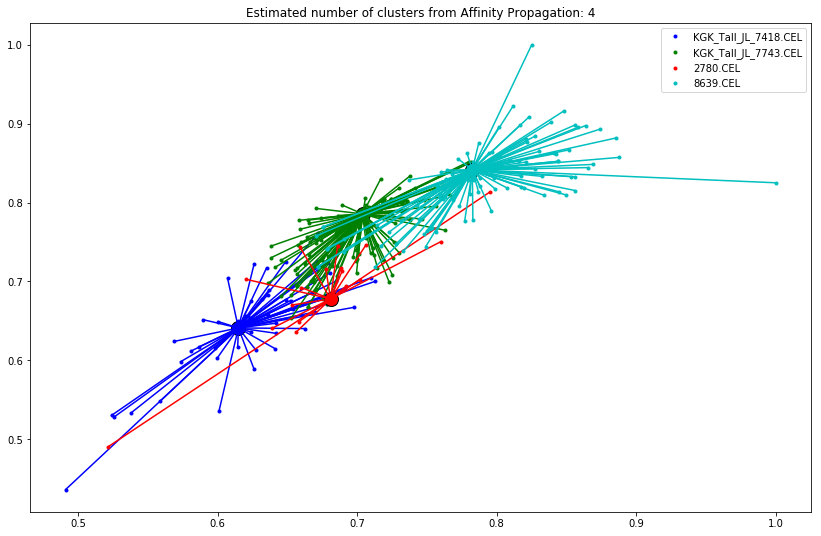

In [104]:
print("Cluster centers:",patient_sim.keys()[cluster_centers_indices].values)
print(patient_cluster_members)

plt.close('all')
plt.figure(figsize=(14,9))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters), colors):
    class_members = patient_cluster_members == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.', 
             label = patient_sim.keys()[cluster_centers_indices[k]])
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.legend()
        
plt.title('Estimated number of clusters from Affinity Propagation: %d' % n_clusters)
plt.show()

In [19]:
##### CREATE graph from similarity matrix
##################
# nodes
VarList = TransPosed.keys()
nodes = []
node_index = 0
for patient_name in VarList:
    nodes.append((node_index, {'name': patient_name}))
    node_index = node_index + 1

edges = []
# edges
patient_sim = patient_similarity(Normal, sim_type = 'pearson', normalised = True, inflation=2)
node_index_x = 0
node_index_y = 0
for patient_name_x in VarList:
    for patient_name_y in VarList:        
        edges.append((node_index_x, node_index_y, patient_sim.iloc[node_index_x, node_index_y]))
        node_index_y = node_index_y + 1
    node_index_x = node_index_x + 1
    node_index_y = 0

In [20]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges, weight = 'weight')

c:\users\bramva~1\envs\worken~1\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
c:\users\bramva~1\envs\worken~1\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
c:\users\bramva~1\envs\worken~1\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
c:\users\bramva~1\envs\worken~1\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is de

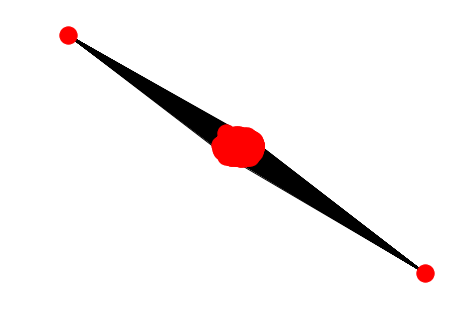

In [23]:
##### apply Spring-force
#######################
pos = nx.spring_layout(G, k = None, dim = 3, scale = 1.0)
nx.draw_spring(G, k = 30, dim = 2, scale = 1.0, iterations =1500)
plt.show()

In [ ]:
##### APPLY community detector
# maximize betweenness and modularity
##################################


In [12]:
##### LOAD IN DATA
###################
# https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns
# 

In [124]:
df = _helpers._preprocess(Rocket.DATA_merged) 
df = _helpers._group_patients(df, method = 'mean')

In [125]:
x,y =_helpers._get_matrix(df, features = 'genomic', target = 'Treatment_risk_group_in_ALL10')

+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


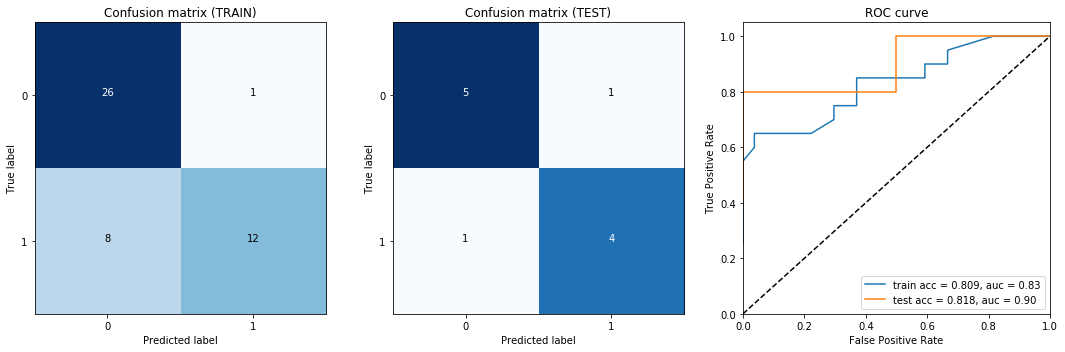

MODEL: ET accuracy:  0.793103448276 +/-: 0.00199527978957
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.94      0.84        33
          1       0.88      0.60      0.71        25

avg / total       0.81      0.79      0.78        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


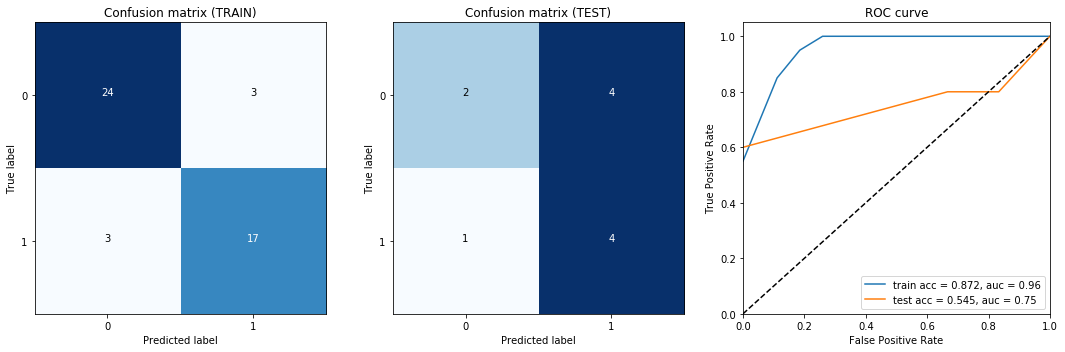

MODEL: CART accuracy:  0.741379310345 +/-: 0.0108321622888
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.85      0.79        33
          1       0.75      0.60      0.67        25

avg / total       0.74      0.74      0.74        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


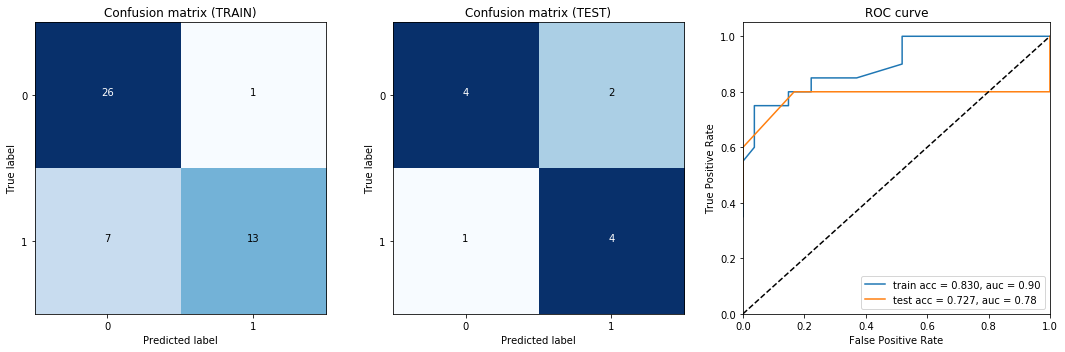

MODEL: RF accuracy:  0.775862068966 +/-: 0.0024006413721
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.75      0.91      0.82        33
          1       0.83      0.60      0.70        25

avg / total       0.79      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


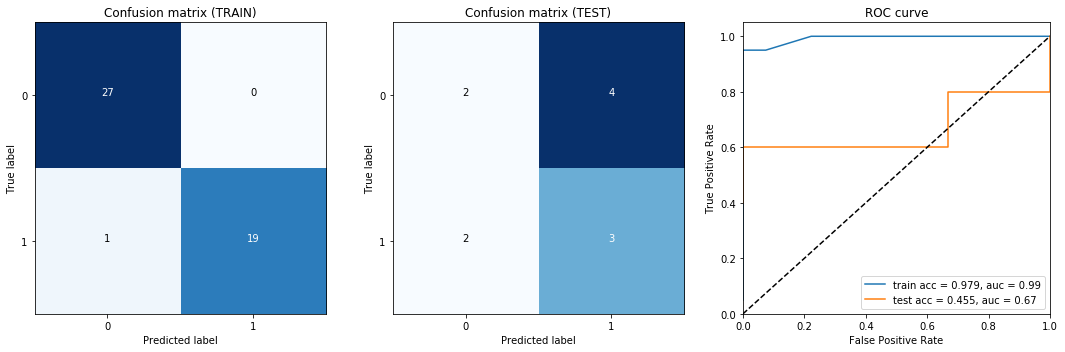

MODEL: GBM accuracy:  0.620689655172 +/-: 0.0207004648146
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.67      0.67      0.67        33
          1       0.56      0.56      0.56        25

avg / total       0.62      0.62      0.62        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


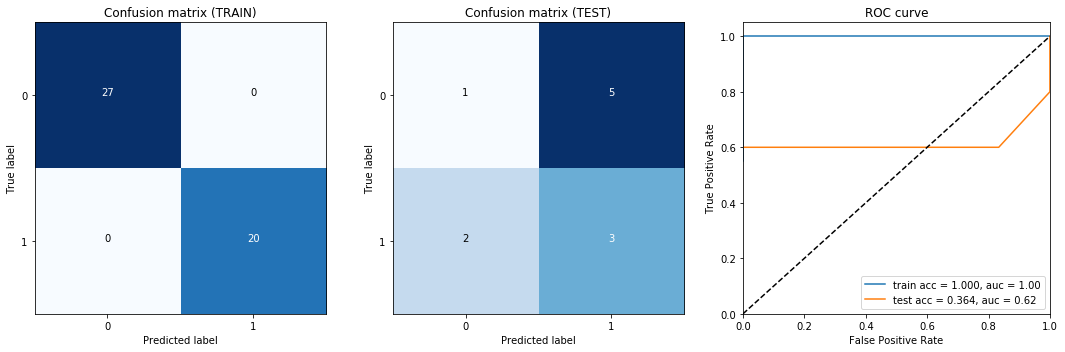

MODEL: ADA accuracy:  0.586206896552 +/-: 0.020912153641
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.65      0.61      0.62        33
          1       0.52      0.56      0.54        25

avg / total       0.59      0.59      0.59        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


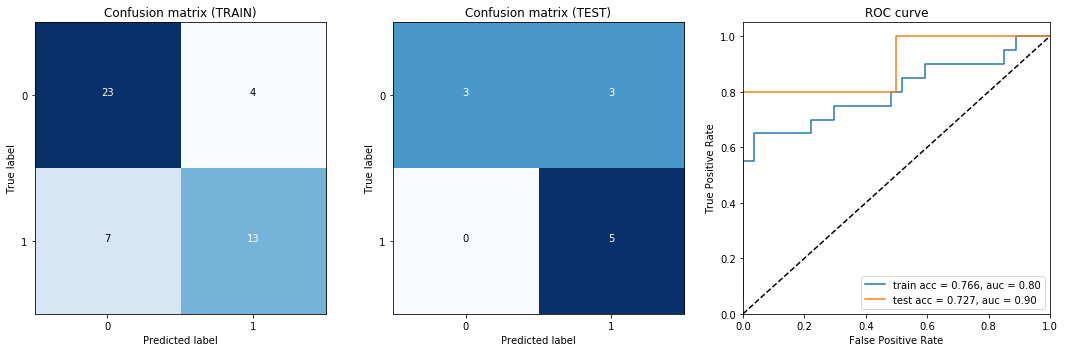

MODEL: LR accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


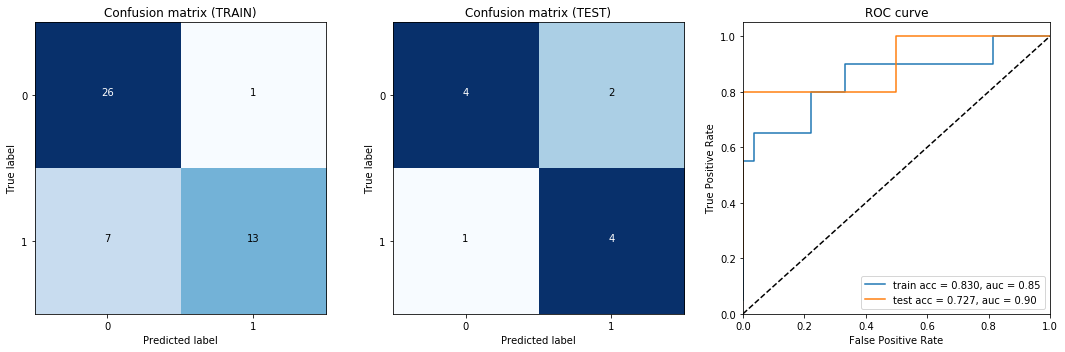

MODEL: SVM accuracy:  0.793103448276 +/-: 0.00826487226606
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.94      0.84        33
          1       0.88      0.60      0.71        25

avg / total       0.81      0.79      0.78        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


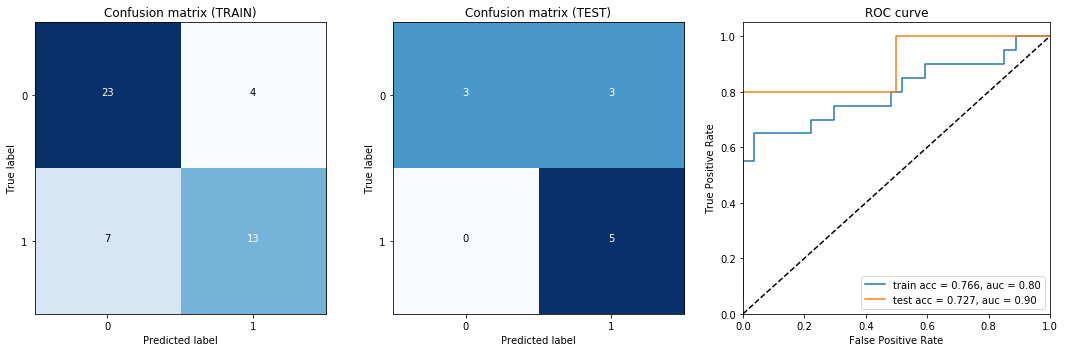

MODEL: GNB accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


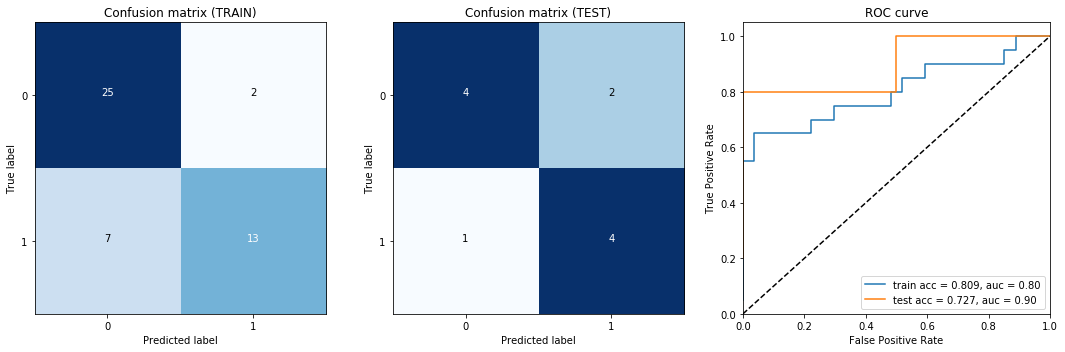

MODEL: MLNN accuracy:  0.775862068966 +/-: 0.00906208337837
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.88      0.82        33
          1       0.80      0.64      0.71        25

avg / total       0.78      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Initial alpha = [[ 0.29814633]]
   1 - L=-1804.8496513 - Gamma= 0.9999702 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-1.0491329397502411e-17
L=-1804.849651326966 - Gamma=0.999970186255669 (M=1) - s=0.01
Initial alpha = [[ 0.19279166]]
   1 - L=-1605.6273696 - Gamma= 0.9999807 (M=   1) - s=0.0100
Stopping at iteration 1 

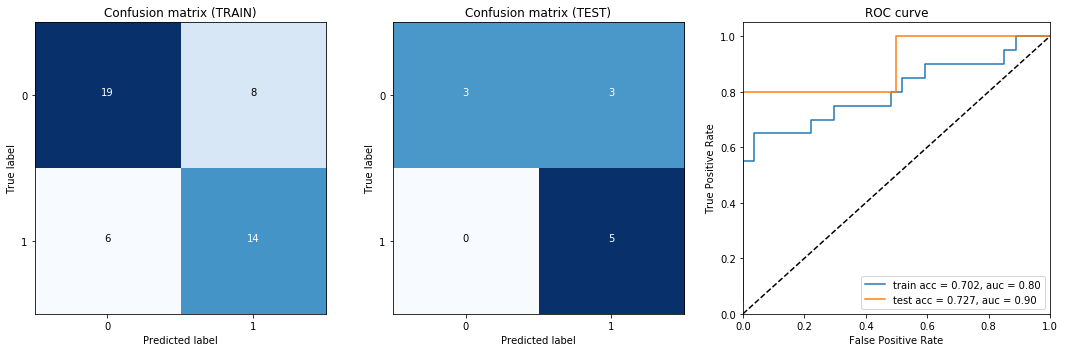

MODEL: RVM accuracy:  0.706896551724 +/-: 0.0277267322452
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.67      0.72        33
          1       0.63      0.76      0.69        25

avg / total       0.72      0.71      0.71        58

Initial alpha = [[ 0.22332277]]
   1 - L=-1764.6402811 - Gamma= 0.9999777 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-2.8460051042002094e-18
L=-1764.640281079869 - Gamma=0.9999776682216228 (M=1) - s=0.01
++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Train on 46 samples, validate on 12 samples
Epoch 1/5
46/46 [==============================] - 0s - loss: 0.7718 - acc:

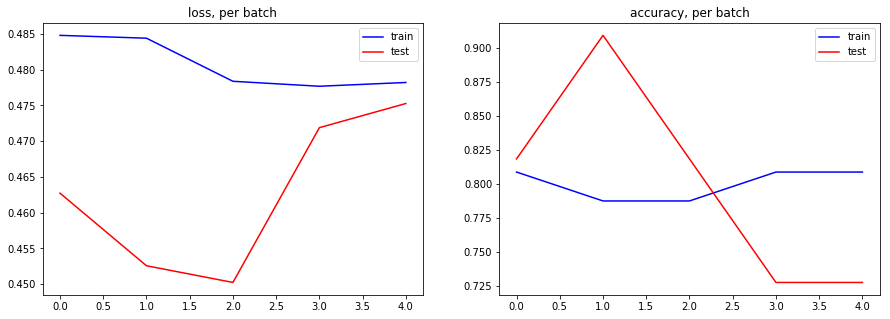

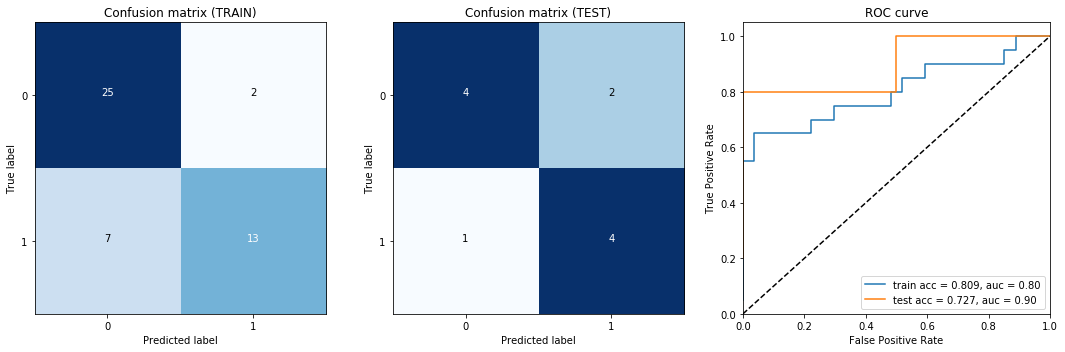

MODEL: DNN accuracy:  0.793103448276 +/-: 0.0121833675639
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.80      0.85      0.82        33
          1       0.78      0.72      0.75        25

avg / total       0.79      0.79      0.79        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


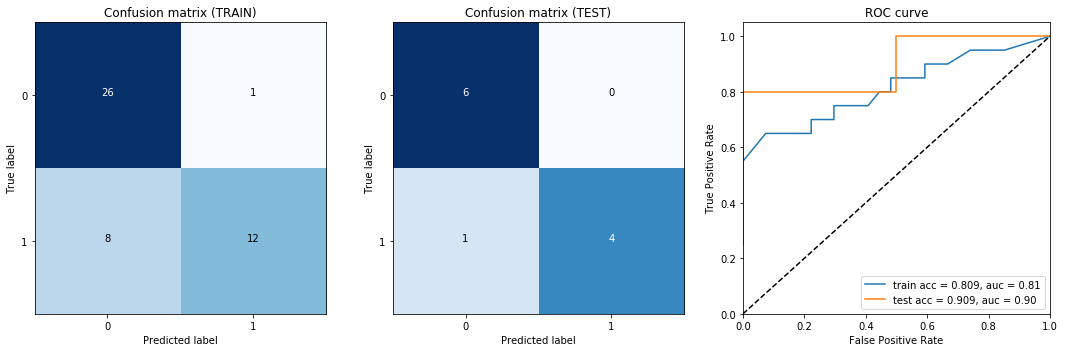

MODEL: ET accuracy:  0.810344827586 +/-: 0.00413018412424
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.97      0.85        33
          1       0.94      0.60      0.73        25

avg / total       0.84      0.81      0.80        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


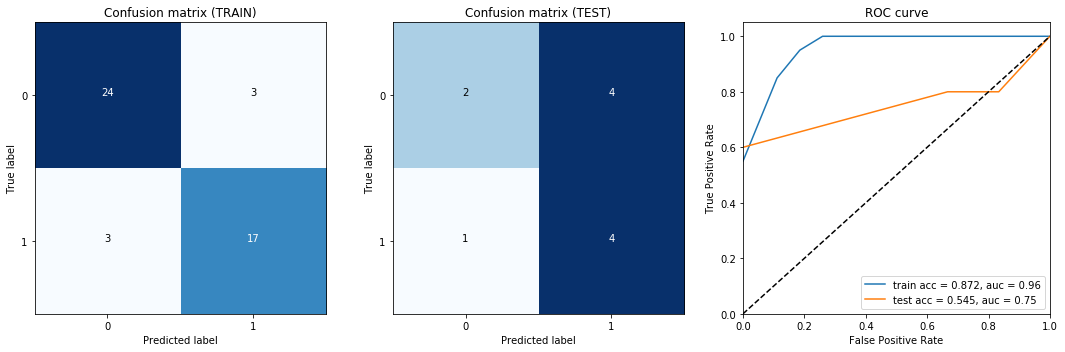

MODEL: CART accuracy:  0.741379310345 +/-: 0.0108321622888
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.85      0.79        33
          1       0.75      0.60      0.67        25

avg / total       0.74      0.74      0.74        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


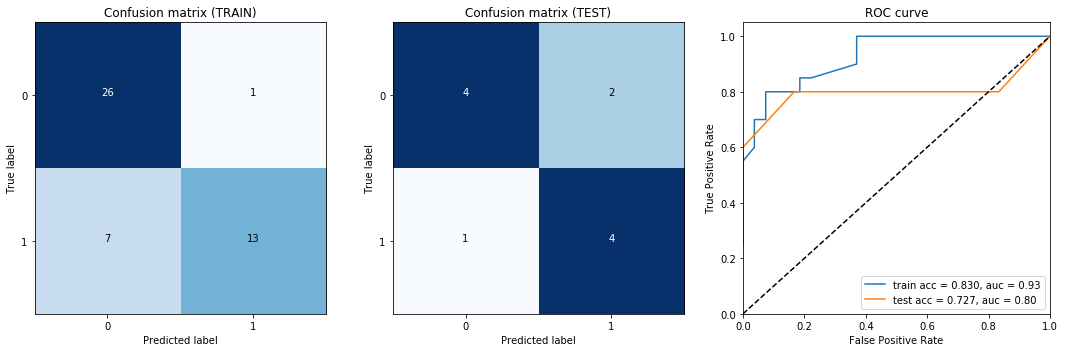

MODEL: RF accuracy:  0.775862068966 +/-: 0.0024006413721
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.75      0.91      0.82        33
          1       0.83      0.60      0.70        25

avg / total       0.79      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


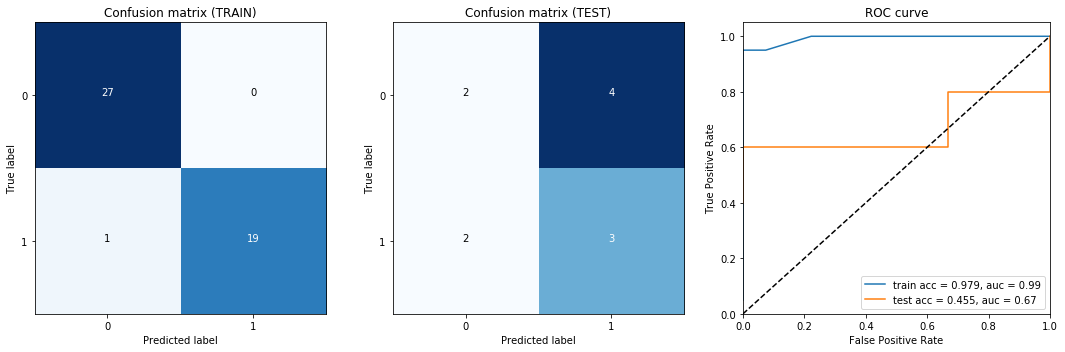

MODEL: GBM accuracy:  0.620689655172 +/-: 0.0207004648146
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.67      0.67      0.67        33
          1       0.56      0.56      0.56        25

avg / total       0.62      0.62      0.62        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


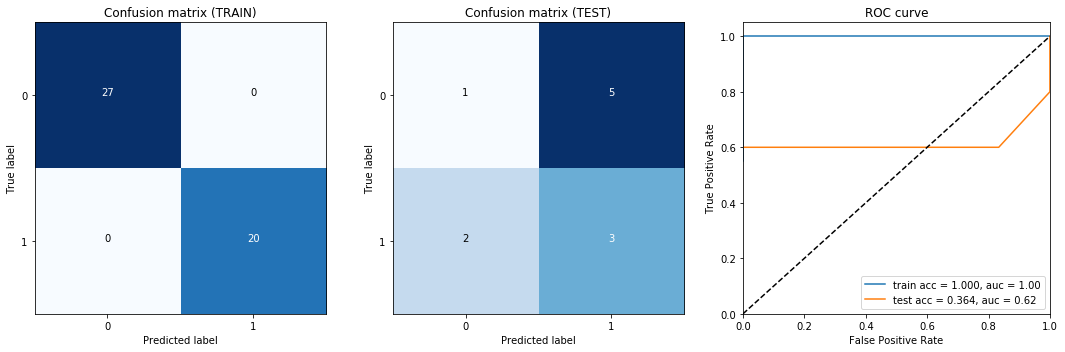

MODEL: ADA accuracy:  0.586206896552 +/-: 0.020912153641
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.65      0.61      0.62        33
          1       0.52      0.56      0.54        25

avg / total       0.59      0.59      0.59        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


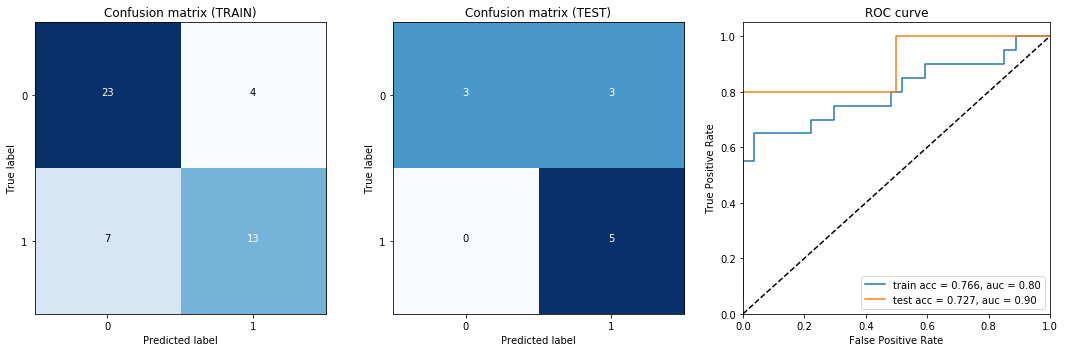

MODEL: LR accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


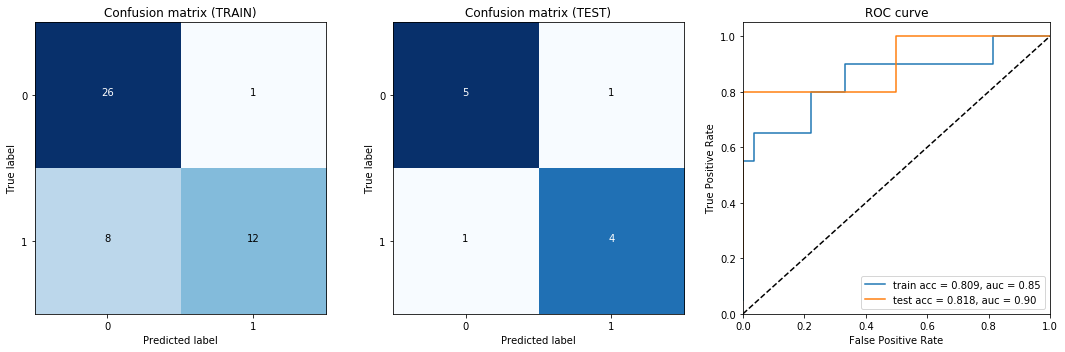

MODEL: SVM accuracy:  0.793103448276 +/-: 0.00826487226606
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.94      0.84        33
          1       0.88      0.60      0.71        25

avg / total       0.81      0.79      0.78        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


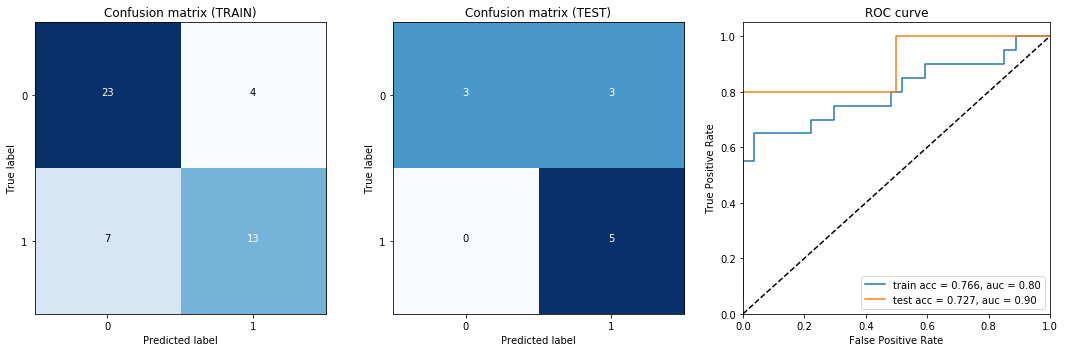

MODEL: GNB accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


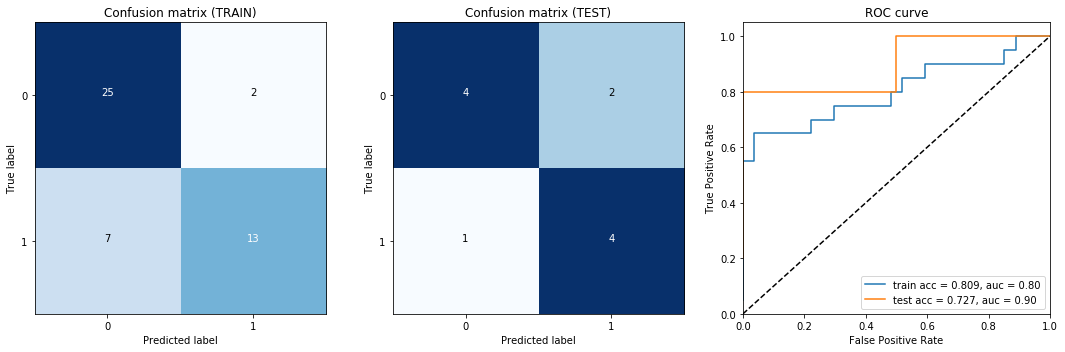

MODEL: MLNN accuracy:  0.775862068966 +/-: 0.00906208337837
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.88      0.82        33
          1       0.80      0.64      0.71        25

avg / total       0.78      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Initial alpha = [[ 0.29814633]]
   1 - L=-1804.8496513 - Gamma= 0.9999702 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-1.0491329397502411e-17
L=-1804.849651326966 - Gamma=0.999970186255669 (M=1) - s=0.01
Initial alpha = [[ 0.19279166]]
   1 - L=-1605.6273696 - Gamma= 0.9999807 (M=   1) - s=0.0100
Stopping at iteration 1 

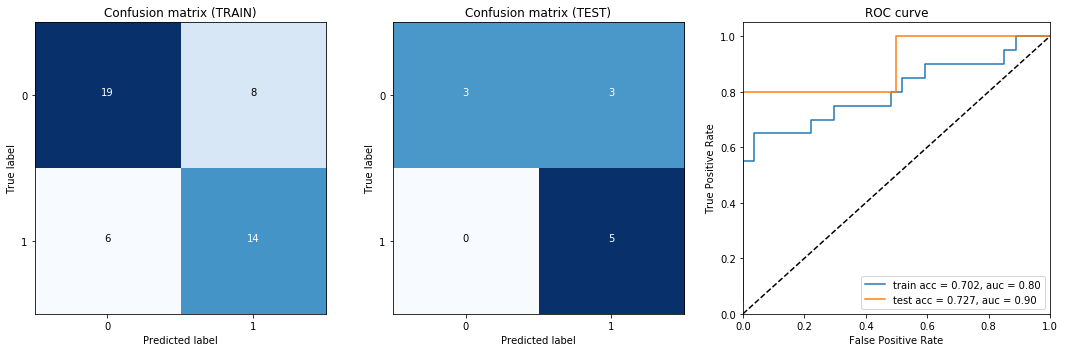

MODEL: RVM accuracy:  0.706896551724 +/-: 0.0277267322452
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.67      0.72        33
          1       0.63      0.76      0.69        25

avg / total       0.72      0.71      0.71        58

Initial alpha = [[ 0.22332277]]
   1 - L=-1764.6402811 - Gamma= 0.9999777 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-2.8460051042002094e-18
L=-1764.640281079869 - Gamma=0.9999776682216228 (M=1) - s=0.01
++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Train on 46 samples, validate on 12 samples
Epoch 1/5
46/46 [==============================] - 0s - loss: 0.9352 - acc:

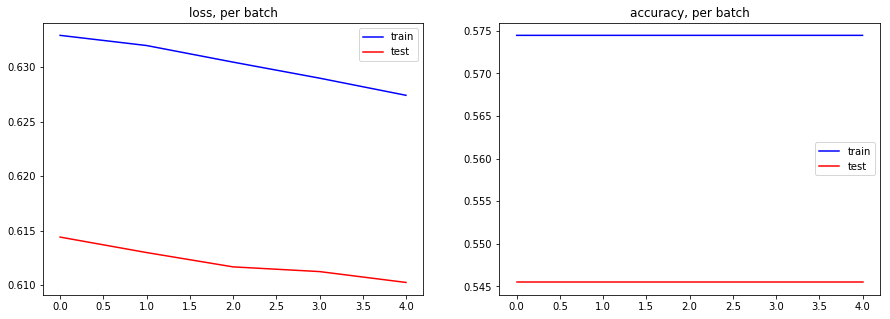

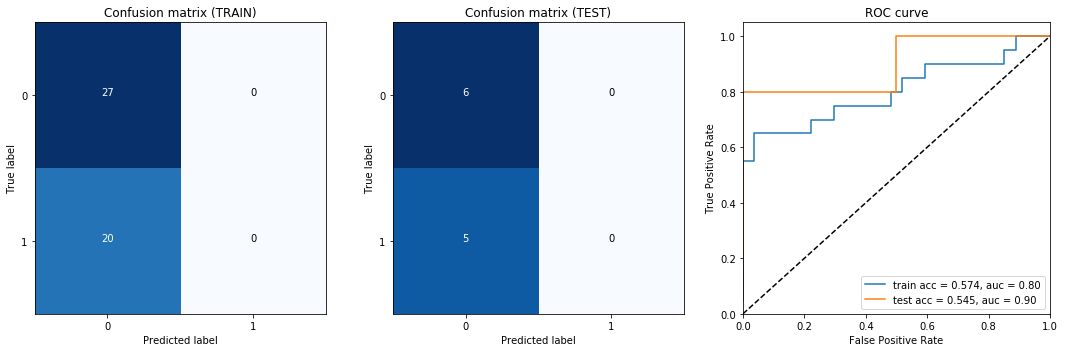

c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


MODEL: DNN accuracy:  0.568965517241 +/-: 0.000337801318776
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.57      1.00      0.73        33
          1       0.00      0.00      0.00        25

avg / total       0.32      0.57      0.41        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


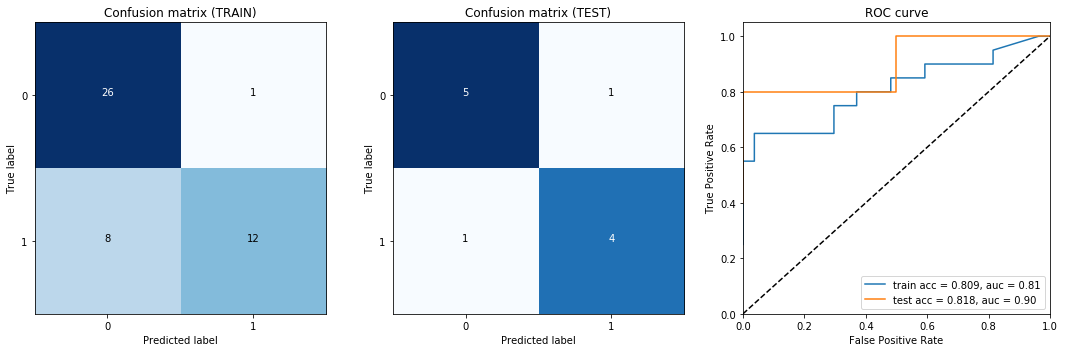

MODEL: ET accuracy:  0.793103448276 +/-: 0.00199527978957
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.94      0.84        33
          1       0.88      0.60      0.71        25

avg / total       0.81      0.79      0.78        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


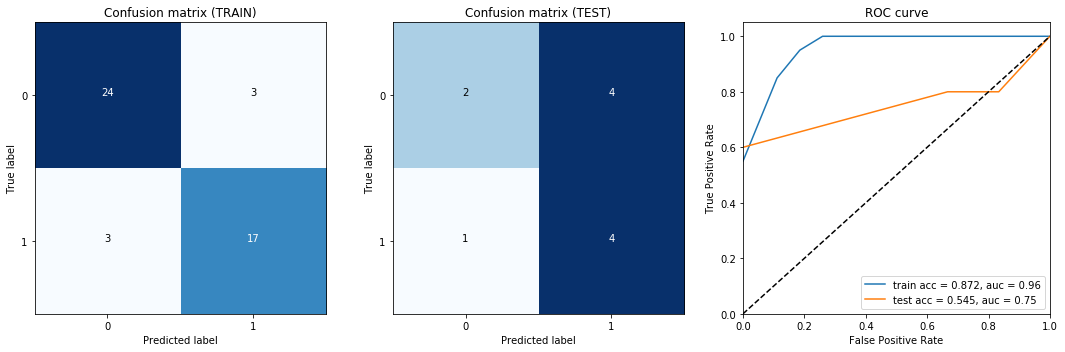

MODEL: CART accuracy:  0.741379310345 +/-: 0.0108321622888
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.85      0.79        33
          1       0.75      0.60      0.67        25

avg / total       0.74      0.74      0.74        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


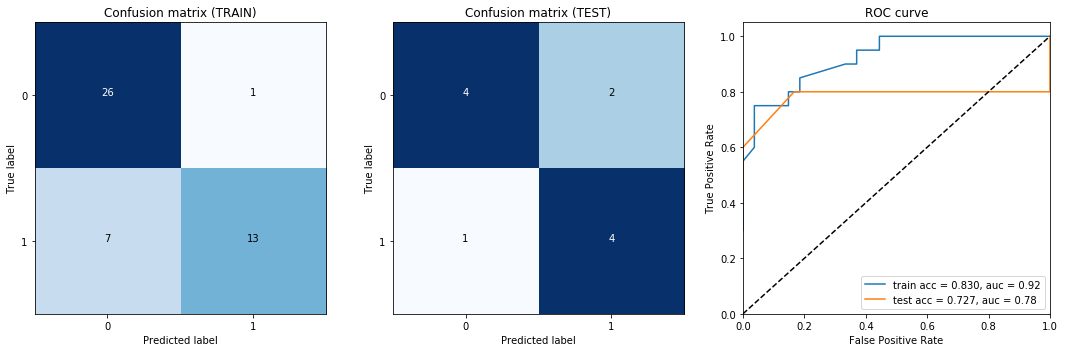

MODEL: RF accuracy:  0.775862068966 +/-: 0.0024006413721
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.75      0.91      0.82        33
          1       0.83      0.60      0.70        25

avg / total       0.79      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


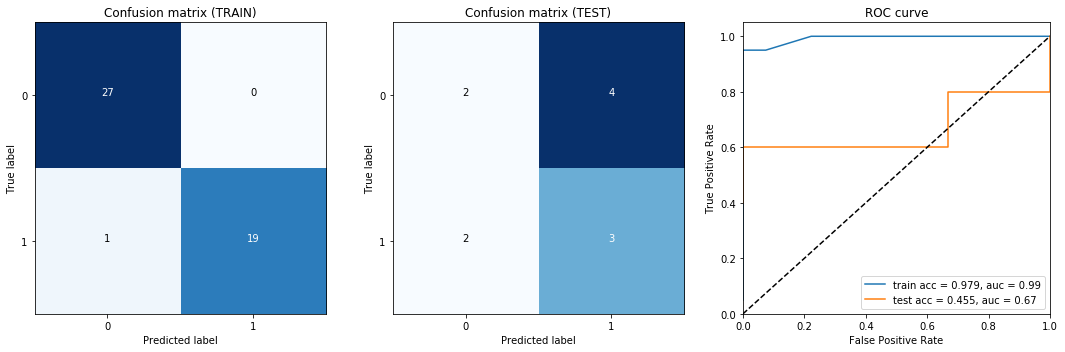

MODEL: GBM accuracy:  0.620689655172 +/-: 0.0207004648146
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.67      0.67      0.67        33
          1       0.56      0.56      0.56        25

avg / total       0.62      0.62      0.62        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


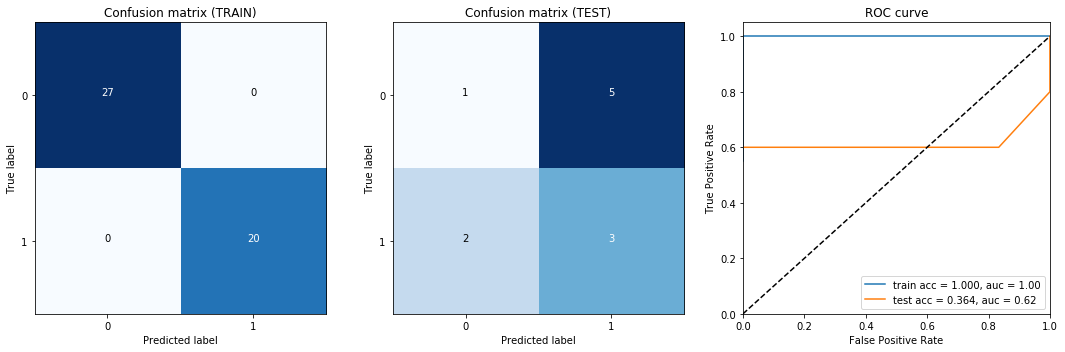

MODEL: ADA accuracy:  0.586206896552 +/-: 0.020912153641
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.65      0.61      0.62        33
          1       0.52      0.56      0.54        25

avg / total       0.59      0.59      0.59        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


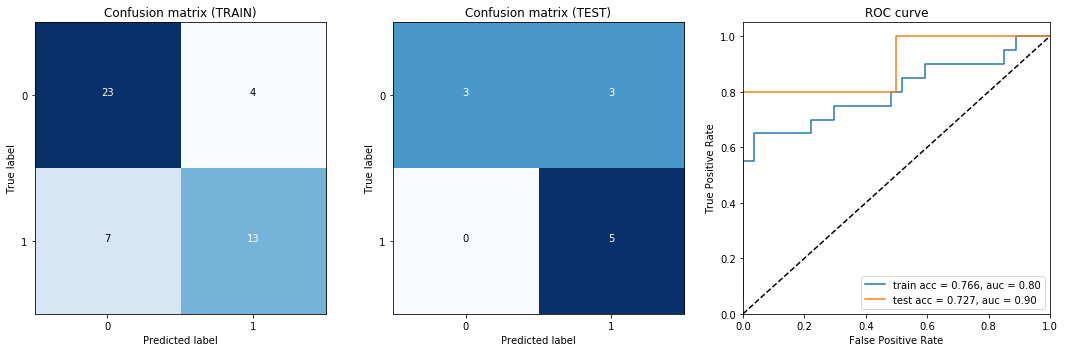

MODEL: LR accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


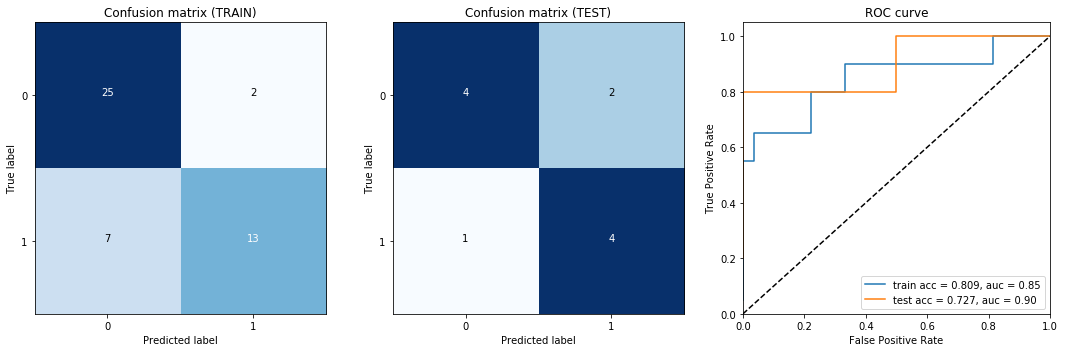

MODEL: SVM accuracy:  0.793103448276 +/-: 0.00826487226606
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.94      0.84        33
          1       0.88      0.60      0.71        25

avg / total       0.81      0.79      0.78        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


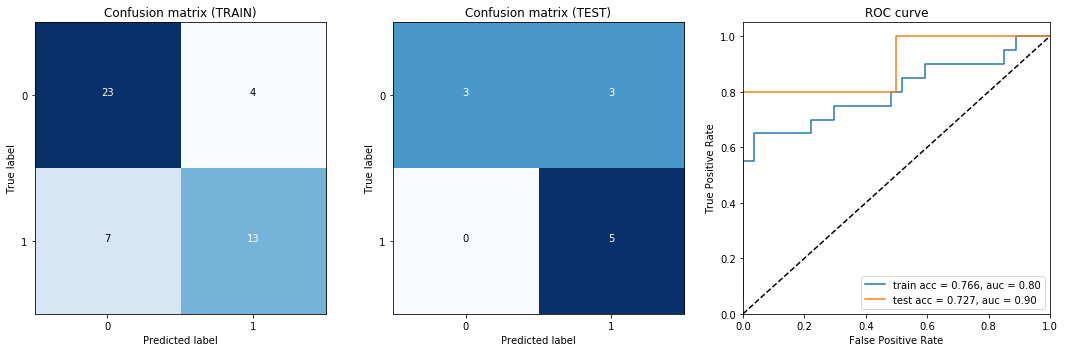

MODEL: GNB accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


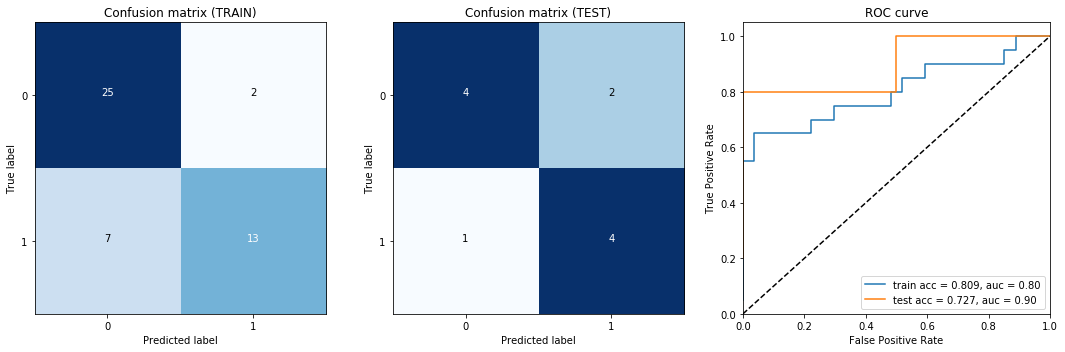

MODEL: MLNN accuracy:  0.775862068966 +/-: 0.00906208337837
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.88      0.82        33
          1       0.80      0.64      0.71        25

avg / total       0.78      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Initial alpha = [[ 0.29814633]]
   1 - L=-1804.8496513 - Gamma= 0.9999702 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-1.0491329397502411e-17
L=-1804.849651326966 - Gamma=0.999970186255669 (M=1) - s=0.01
Initial alpha = [[ 0.19279166]]
   1 - L=-1605.6273696 - Gamma= 0.9999807 (M=   1) - s=0.0100
Stopping at iteration 1 

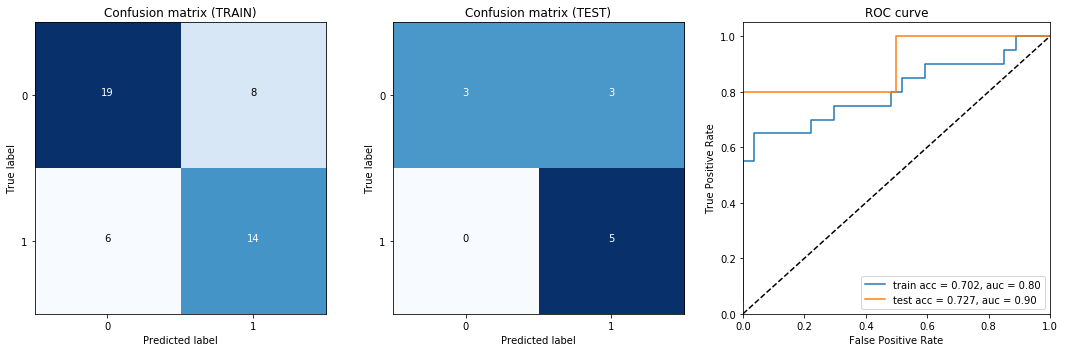

MODEL: RVM accuracy:  0.706896551724 +/-: 0.0277267322452
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.67      0.72        33
          1       0.63      0.76      0.69        25

avg / total       0.72      0.71      0.71        58

Initial alpha = [[ 0.22332277]]
   1 - L=-1764.6402811 - Gamma= 0.9999777 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-2.8460051042002094e-18
L=-1764.640281079869 - Gamma=0.9999776682216228 (M=1) - s=0.01
++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Train on 46 samples, validate on 12 samples
Epoch 1/5
46/46 [==============================] - 0s - loss: 0.6990 - acc:

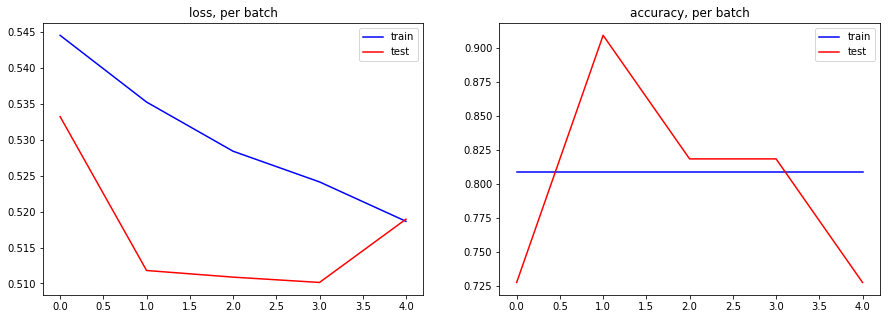

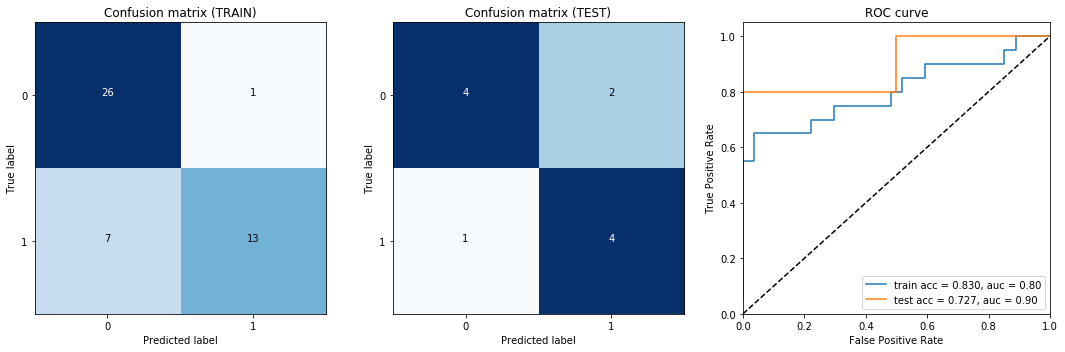

MODEL: DNN accuracy:  0.706896551724 +/-: 0.00787302273628
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.69      0.88      0.77        33
          1       0.75      0.48      0.59        25

avg / total       0.72      0.71      0.69        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


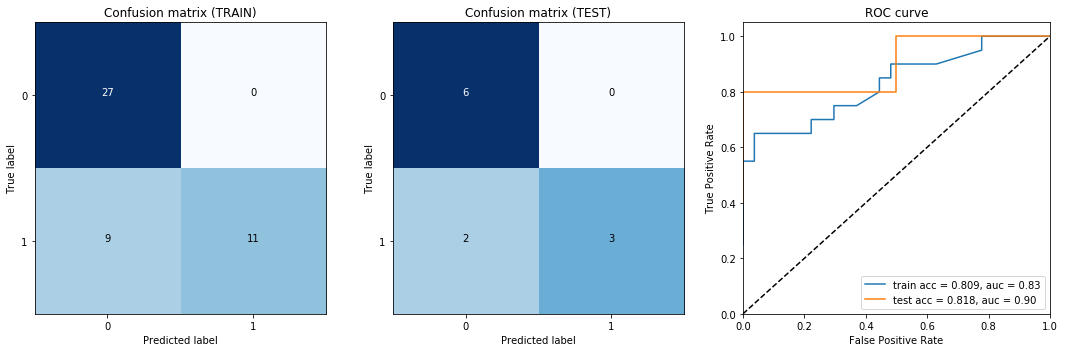

MODEL: ET accuracy:  0.793103448276 +/-: 0.00199527978957
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.97      0.84        33
          1       0.93      0.56      0.70        25

avg / total       0.83      0.79      0.78        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


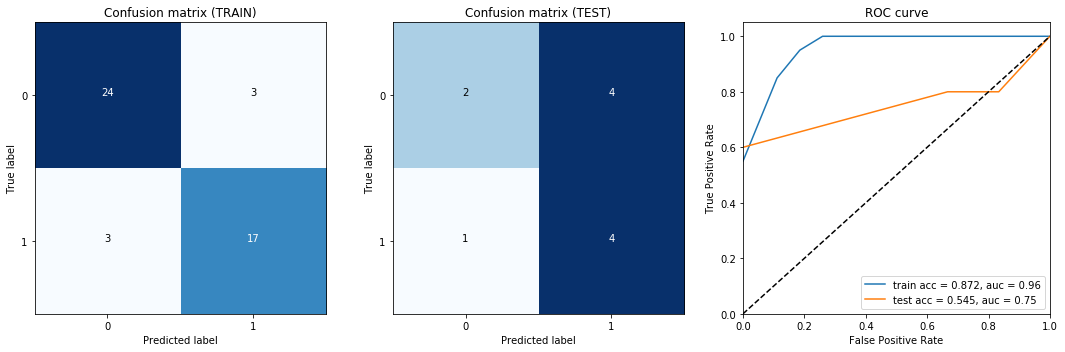

MODEL: CART accuracy:  0.741379310345 +/-: 0.0108321622888
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.85      0.79        33
          1       0.75      0.60      0.67        25

avg / total       0.74      0.74      0.74        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


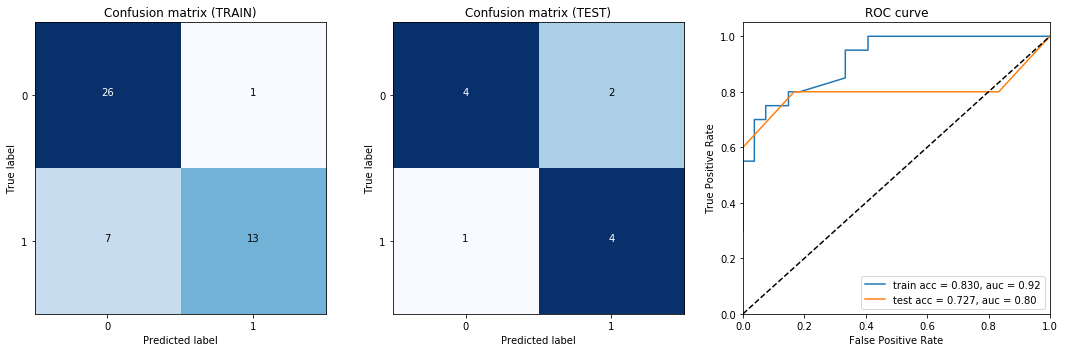

MODEL: RF accuracy:  0.758620689655 +/-: 0.00534626887183
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.88      0.81        33
          1       0.79      0.60      0.68        25

avg / total       0.76      0.76      0.75        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


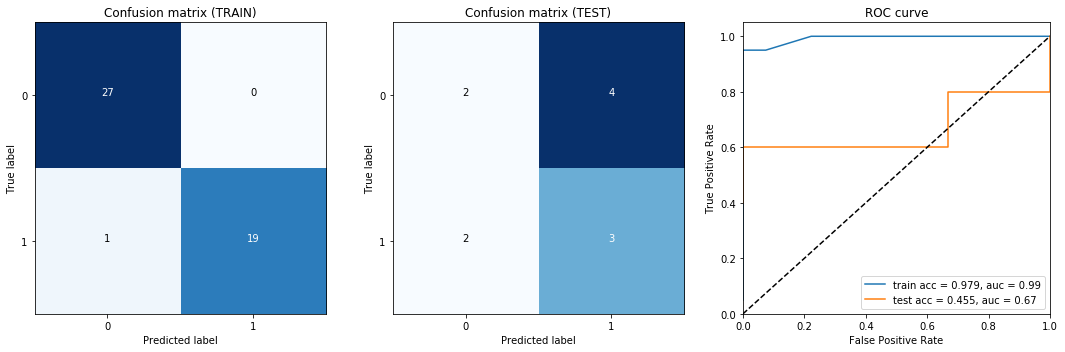

MODEL: GBM accuracy:  0.620689655172 +/-: 0.0207004648146
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.67      0.67      0.67        33
          1       0.56      0.56      0.56        25

avg / total       0.62      0.62      0.62        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


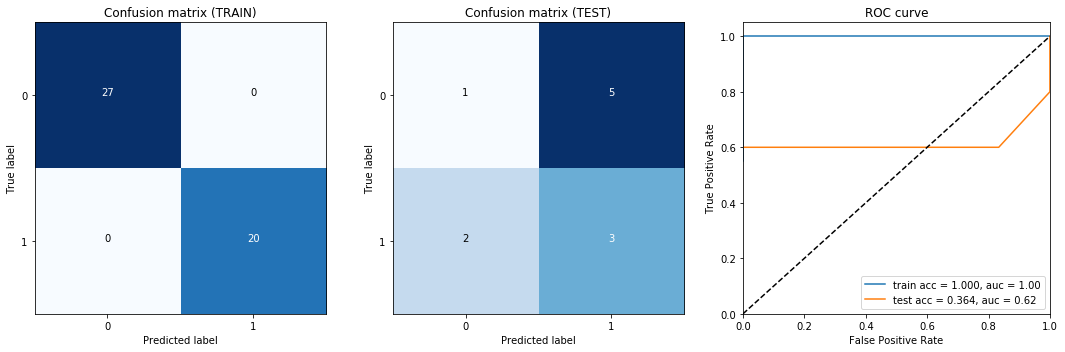

MODEL: ADA accuracy:  0.586206896552 +/-: 0.020912153641
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.65      0.61      0.62        33
          1       0.52      0.56      0.54        25

avg / total       0.59      0.59      0.59        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


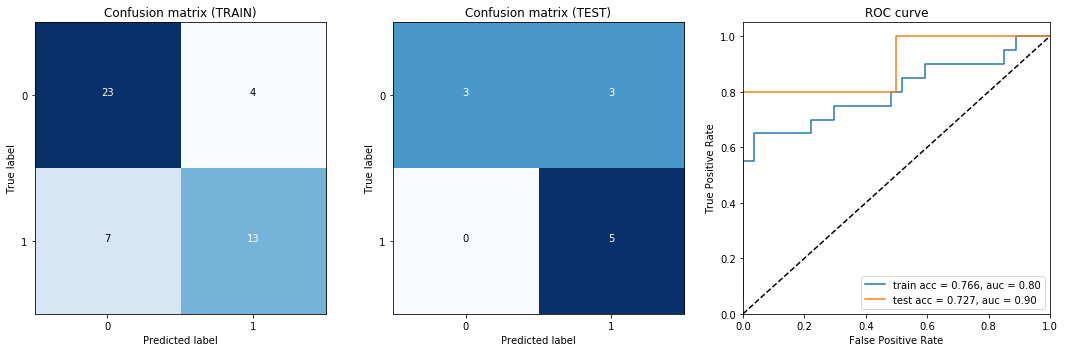

MODEL: LR accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


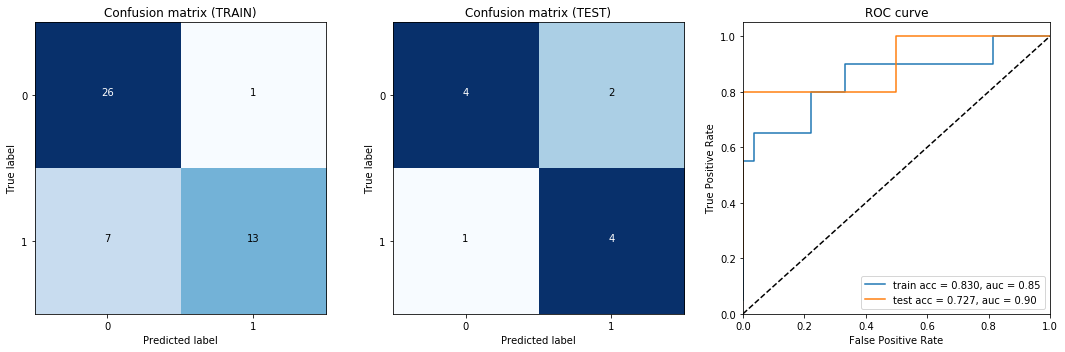

MODEL: SVM accuracy:  0.793103448276 +/-: 0.00826487226606
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.94      0.84        33
          1       0.88      0.60      0.71        25

avg / total       0.81      0.79      0.78        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


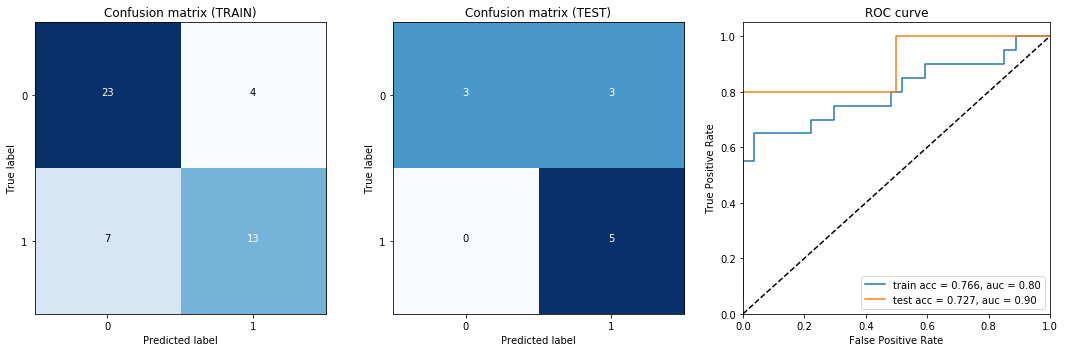

MODEL: GNB accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


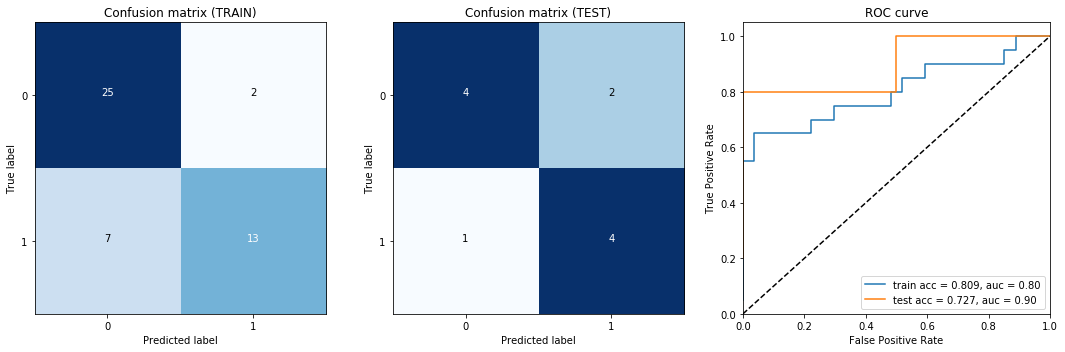

MODEL: MLNN accuracy:  0.775862068966 +/-: 0.00906208337837
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.88      0.82        33
          1       0.80      0.64      0.71        25

avg / total       0.78      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Initial alpha = [[ 0.29814633]]
   1 - L=-1804.8496513 - Gamma= 0.9999702 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-1.0491329397502411e-17
L=-1804.849651326966 - Gamma=0.999970186255669 (M=1) - s=0.01
Initial alpha = [[ 0.19279166]]
   1 - L=-1605.6273696 - Gamma= 0.9999807 (M=   1) - s=0.0100
Stopping at iteration 1 

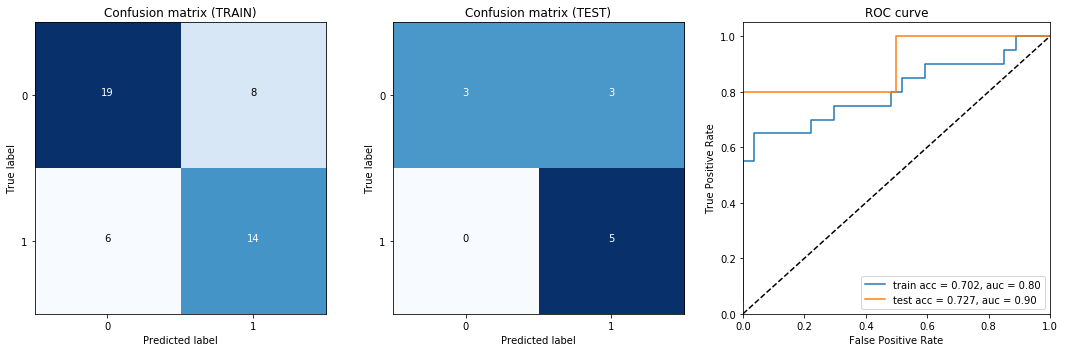

MODEL: RVM accuracy:  0.706896551724 +/-: 0.0277267322452
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.67      0.72        33
          1       0.63      0.76      0.69        25

avg / total       0.72      0.71      0.71        58

Initial alpha = [[ 0.22332277]]
   1 - L=-1764.6402811 - Gamma= 0.9999777 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-2.8460051042002094e-18
L=-1764.640281079869 - Gamma=0.9999776682216228 (M=1) - s=0.01
++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Train on 46 samples, validate on 12 samples
Epoch 1/5
46/46 [==============================] - 0s - loss: 0.6832 - acc:

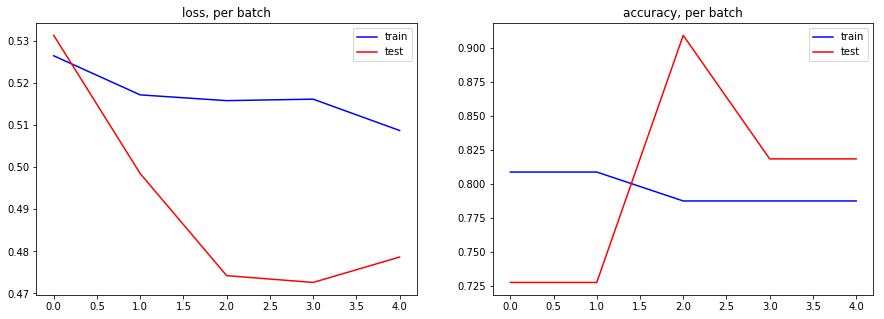

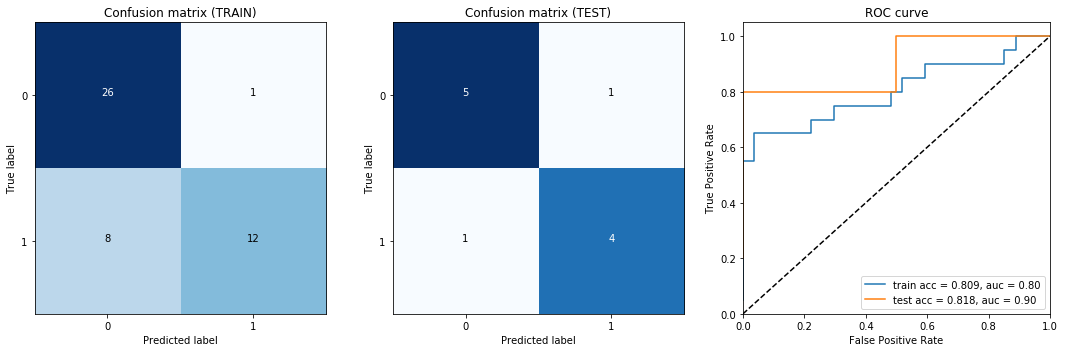

MODEL: DNN accuracy:  0.775862068966 +/-: 0.00553543761035
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.75      0.91      0.82        33
          1       0.83      0.60      0.70        25

avg / total       0.79      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


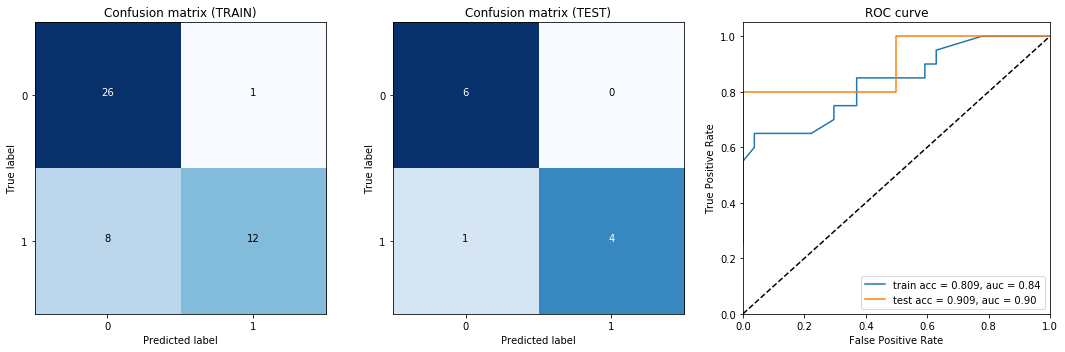

MODEL: ET accuracy:  0.793103448276 +/-: 0.00826487226606
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.94      0.84        33
          1       0.88      0.60      0.71        25

avg / total       0.81      0.79      0.78        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


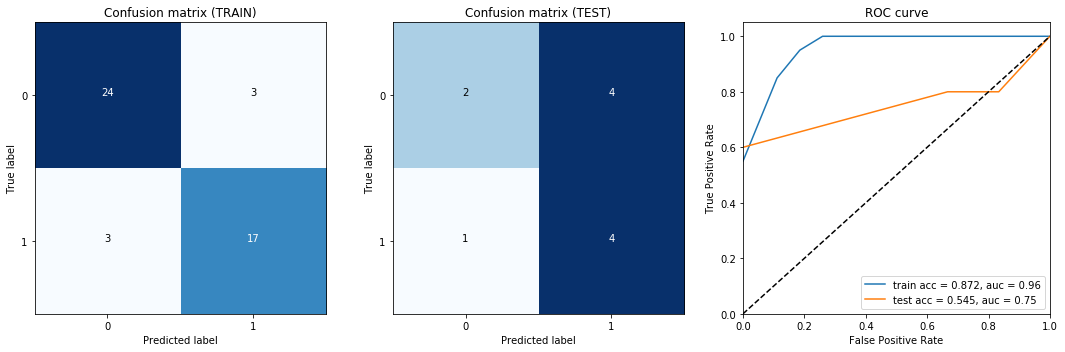

MODEL: CART accuracy:  0.741379310345 +/-: 0.0108321622888
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.85      0.79        33
          1       0.75      0.60      0.67        25

avg / total       0.74      0.74      0.74        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


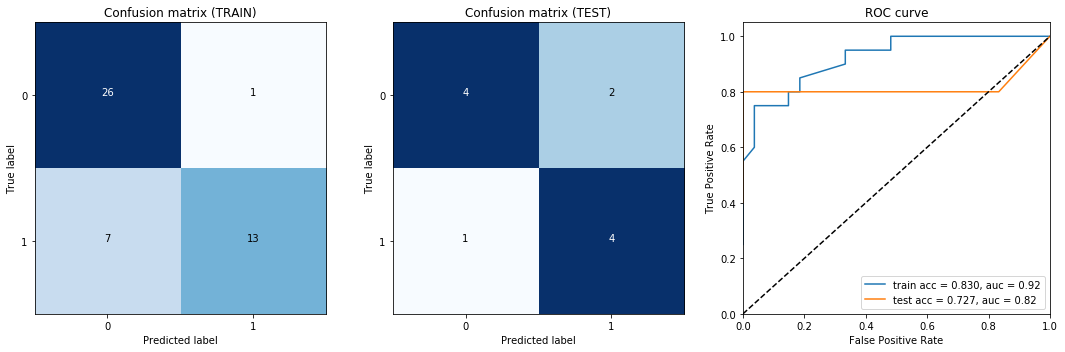

MODEL: RF accuracy:  0.775862068966 +/-: 0.0024006413721
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.75      0.91      0.82        33
          1       0.83      0.60      0.70        25

avg / total       0.79      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


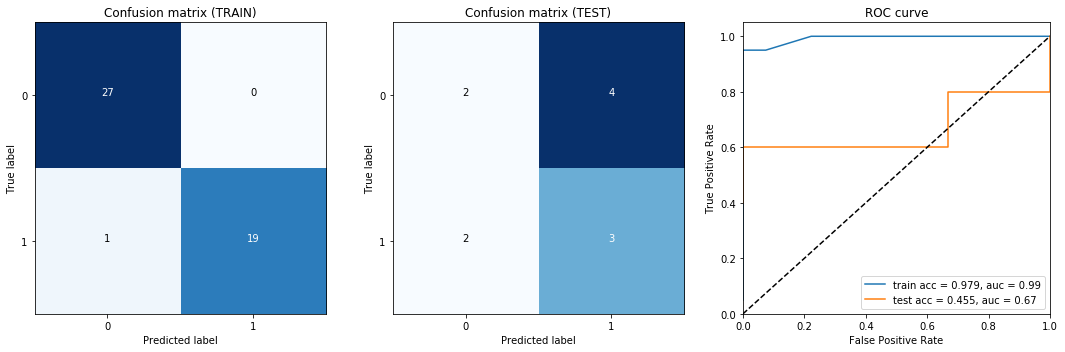

MODEL: GBM accuracy:  0.620689655172 +/-: 0.0207004648146
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.67      0.67      0.67        33
          1       0.56      0.56      0.56        25

avg / total       0.62      0.62      0.62        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


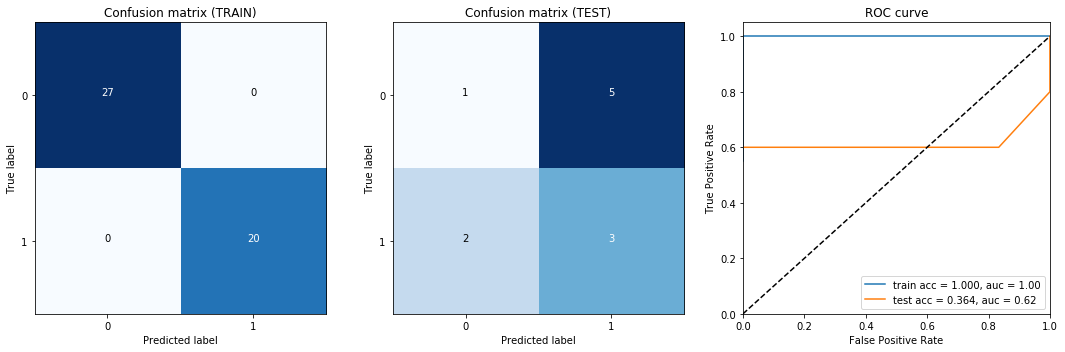

MODEL: ADA accuracy:  0.586206896552 +/-: 0.020912153641
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.65      0.61      0.62        33
          1       0.52      0.56      0.54        25

avg / total       0.59      0.59      0.59        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


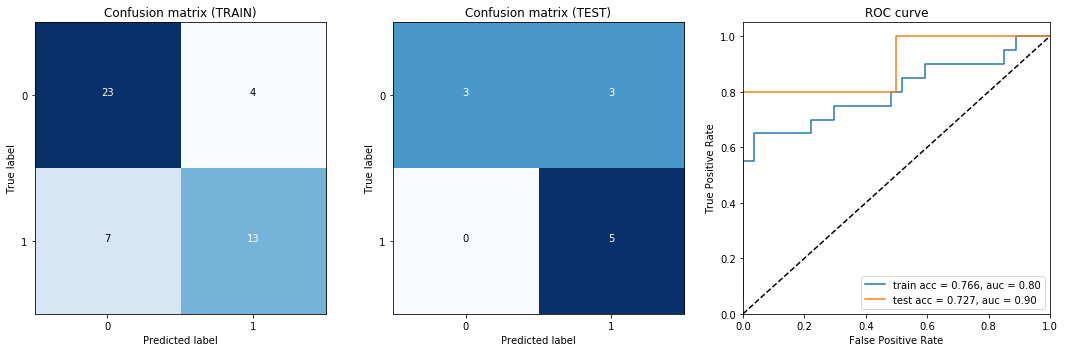

MODEL: LR accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


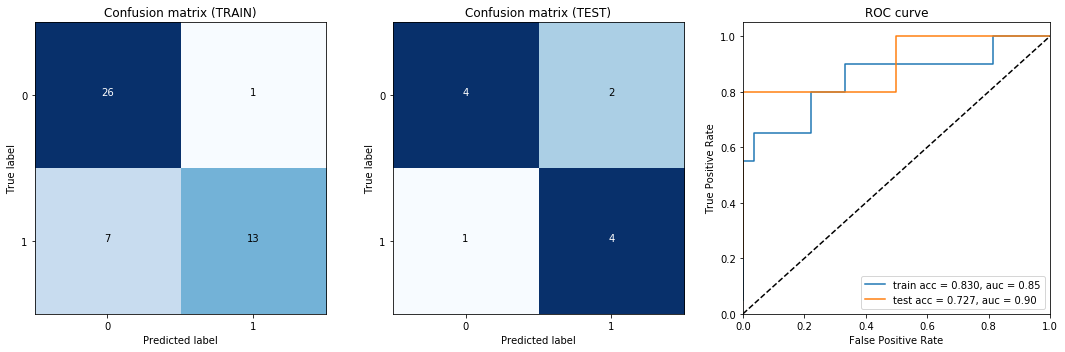

MODEL: SVM accuracy:  0.793103448276 +/-: 0.00826487226606
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.94      0.84        33
          1       0.88      0.60      0.71        25

avg / total       0.81      0.79      0.78        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


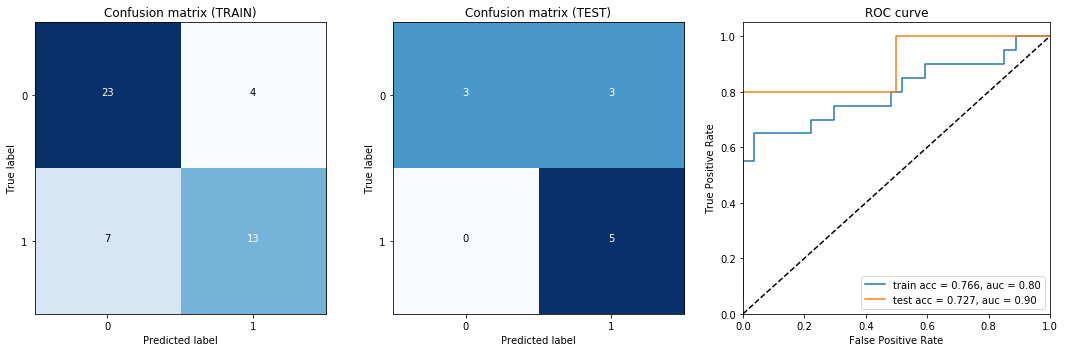

MODEL: GNB accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


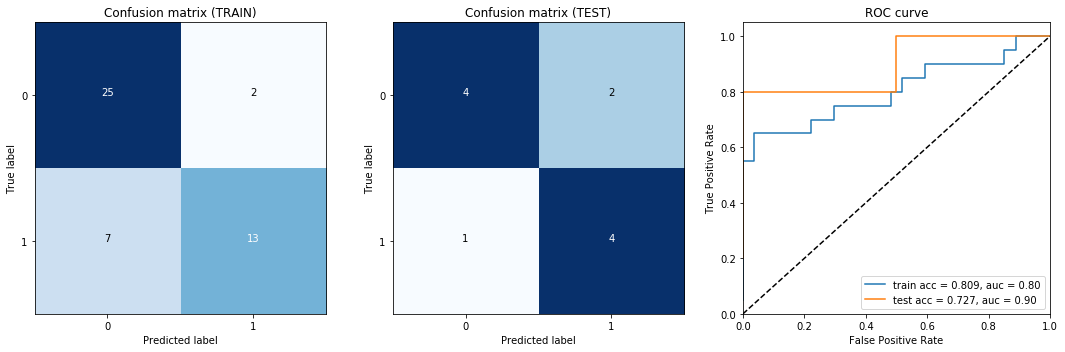

MODEL: MLNN accuracy:  0.775862068966 +/-: 0.00906208337837
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.88      0.82        33
          1       0.80      0.64      0.71        25

avg / total       0.78      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Initial alpha = [[ 0.29814633]]
   1 - L=-1804.8496513 - Gamma= 0.9999702 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-1.0491329397502411e-17
L=-1804.849651326966 - Gamma=0.999970186255669 (M=1) - s=0.01
Initial alpha = [[ 0.19279166]]
   1 - L=-1605.6273696 - Gamma= 0.9999807 (M=   1) - s=0.0100
Stopping at iteration 1 

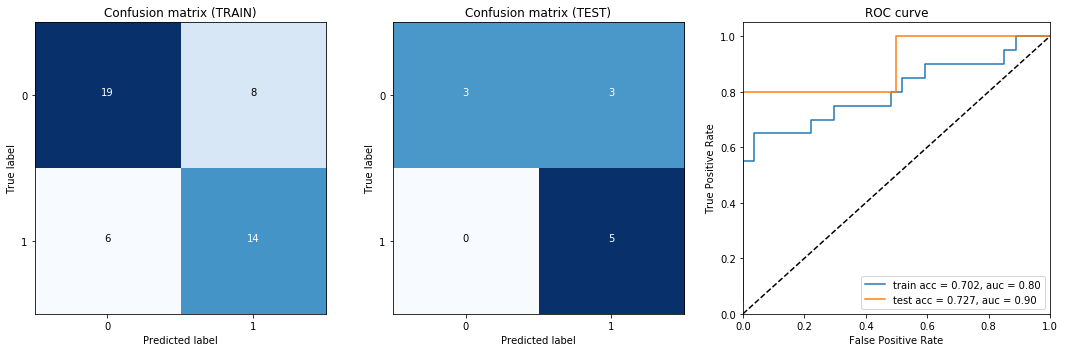

MODEL: RVM accuracy:  0.706896551724 +/-: 0.0277267322452
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.67      0.72        33
          1       0.63      0.76      0.69        25

avg / total       0.72      0.71      0.71        58

Initial alpha = [[ 0.22332277]]
   1 - L=-1764.6402811 - Gamma= 0.9999777 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-2.8460051042002094e-18
L=-1764.640281079869 - Gamma=0.9999776682216228 (M=1) - s=0.01
++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Train on 46 samples, validate on 12 samples
Epoch 1/5
46/46 [==============================] - 0s - loss: 0.9918 - acc:

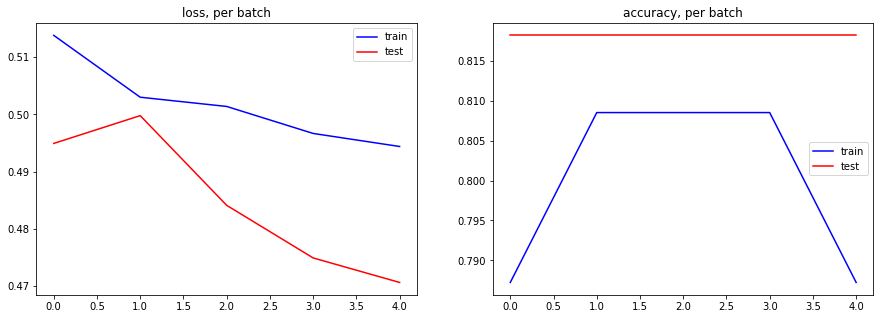

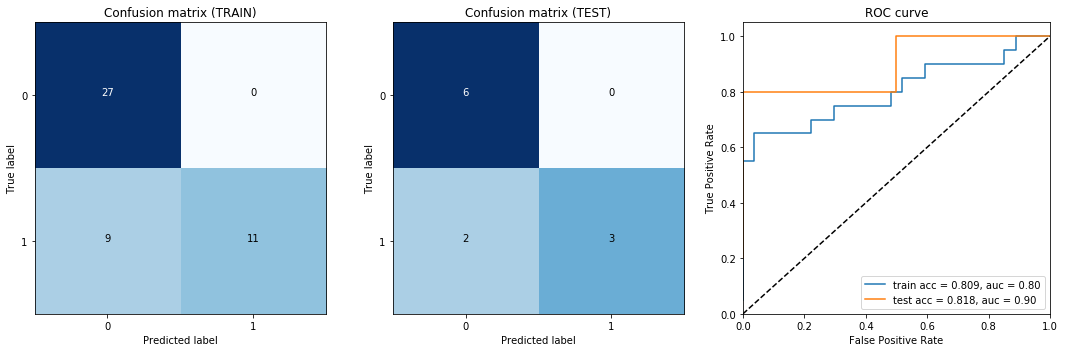

MODEL: DNN accuracy:  0.655172413793 +/-: 0.0437114906497
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.78      0.55      0.64        33
          1       0.57      0.80      0.67        25

avg / total       0.69      0.66      0.65        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


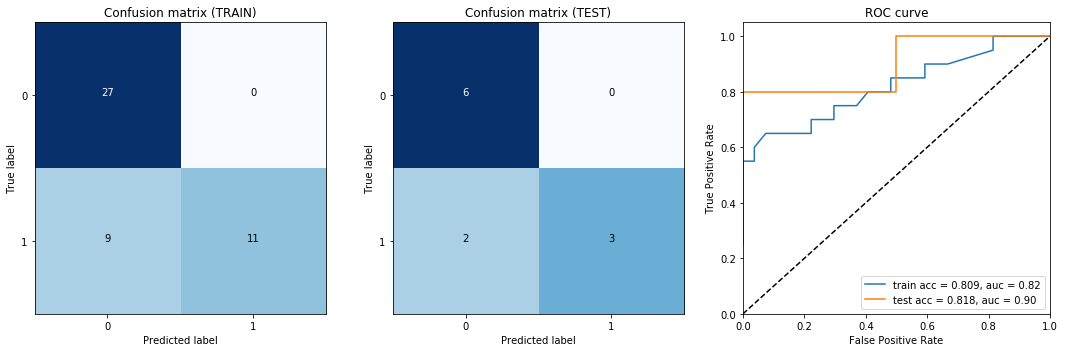

MODEL: ET accuracy:  0.793103448276 +/-: 0.00199527978957
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.97      0.84        33
          1       0.93      0.56      0.70        25

avg / total       0.83      0.79      0.78        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


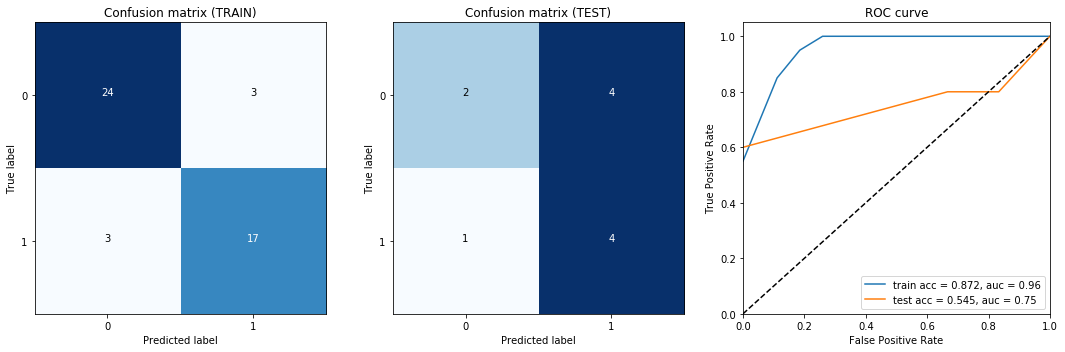

MODEL: CART accuracy:  0.741379310345 +/-: 0.0108321622888
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.85      0.79        33
          1       0.75      0.60      0.67        25

avg / total       0.74      0.74      0.74        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


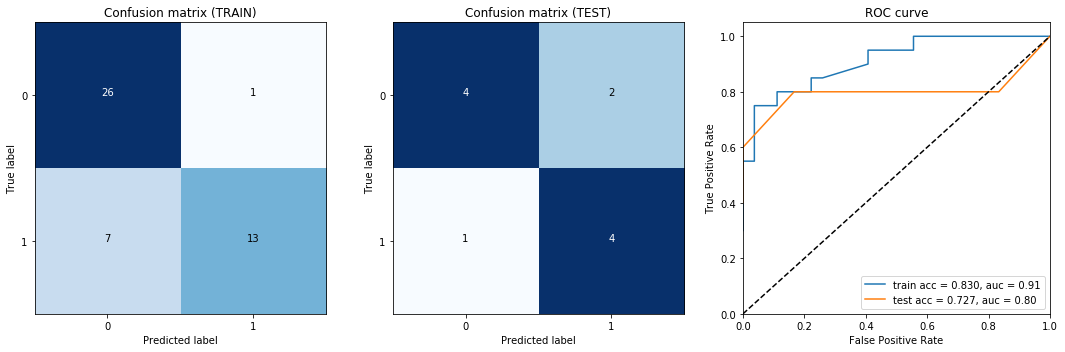

MODEL: RF accuracy:  0.758620689655 +/-: 0.00534626887183
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.88      0.81        33
          1       0.79      0.60      0.68        25

avg / total       0.76      0.76      0.75        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


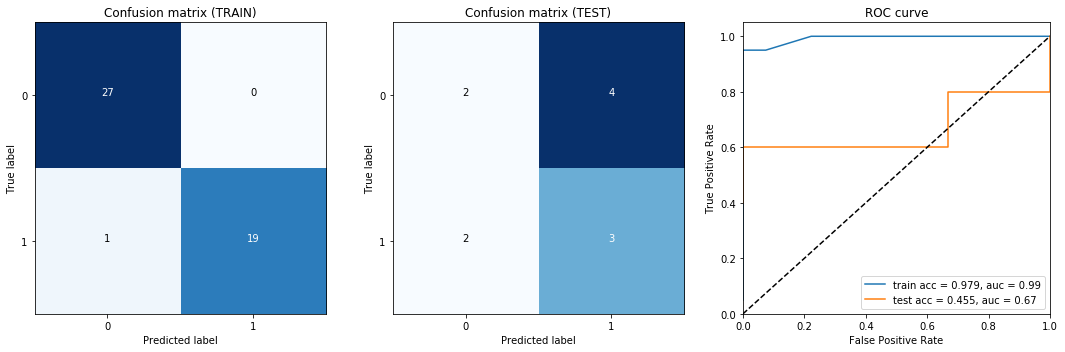

MODEL: GBM accuracy:  0.620689655172 +/-: 0.0207004648146
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.67      0.67      0.67        33
          1       0.56      0.56      0.56        25

avg / total       0.62      0.62      0.62        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


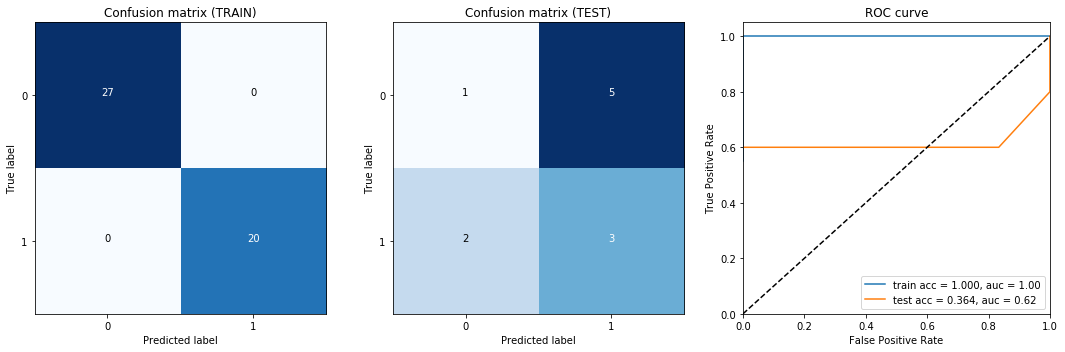

MODEL: ADA accuracy:  0.586206896552 +/-: 0.020912153641
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.65      0.61      0.62        33
          1       0.52      0.56      0.54        25

avg / total       0.59      0.59      0.59        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


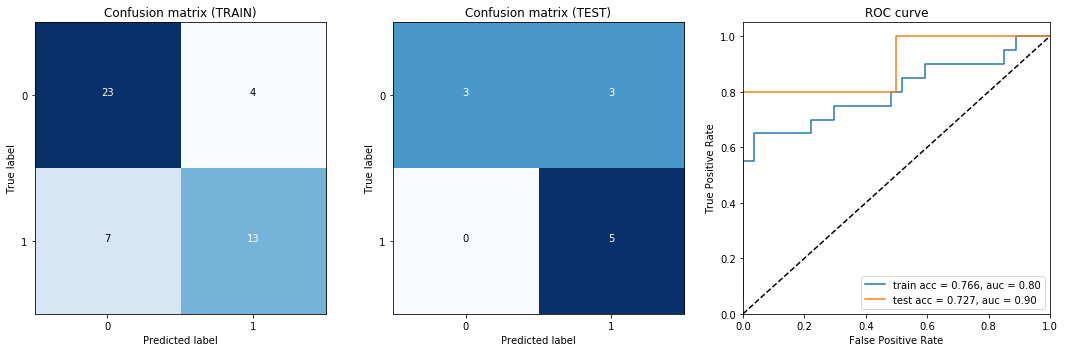

MODEL: LR accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


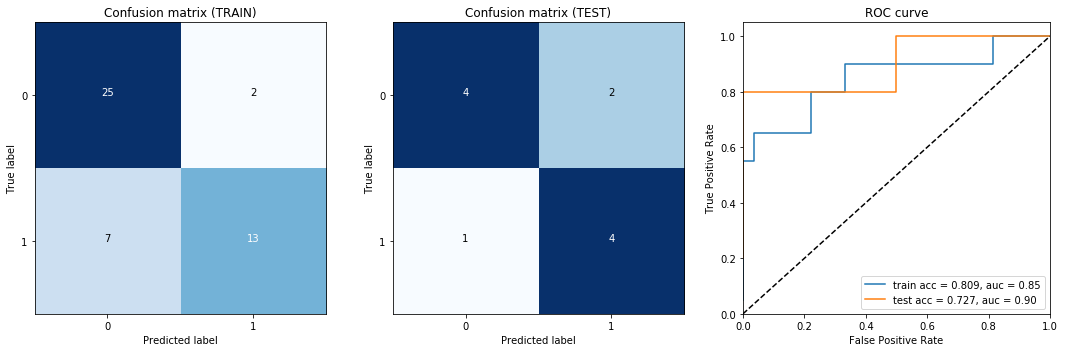

MODEL: SVM accuracy:  0.793103448276 +/-: 0.00826487226606
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.94      0.84        33
          1       0.88      0.60      0.71        25

avg / total       0.81      0.79      0.78        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


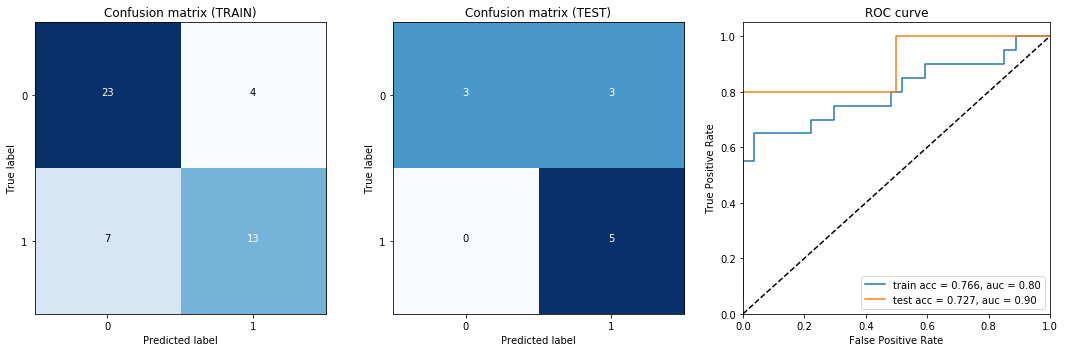

MODEL: GNB accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


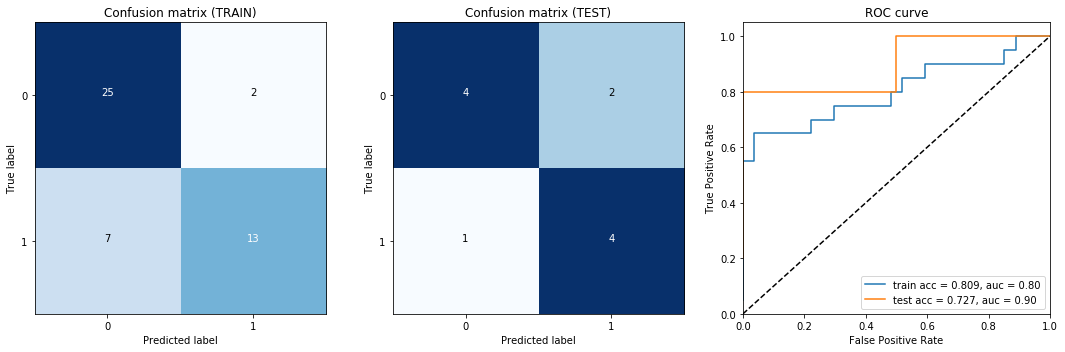

MODEL: MLNN accuracy:  0.775862068966 +/-: 0.00906208337837
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.88      0.82        33
          1       0.80      0.64      0.71        25

avg / total       0.78      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Initial alpha = [[ 0.29814633]]
   1 - L=-1804.8496513 - Gamma= 0.9999702 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-1.0491329397502411e-17
L=-1804.849651326966 - Gamma=0.999970186255669 (M=1) - s=0.01
Initial alpha = [[ 0.19279166]]
   1 - L=-1605.6273696 - Gamma= 0.9999807 (M=   1) - s=0.0100
Stopping at iteration 1 

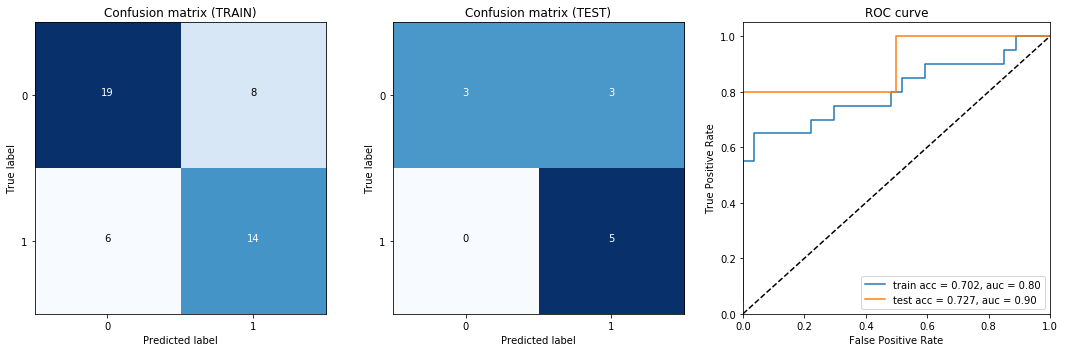

MODEL: RVM accuracy:  0.706896551724 +/-: 0.0277267322452
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.67      0.72        33
          1       0.63      0.76      0.69        25

avg / total       0.72      0.71      0.71        58

Initial alpha = [[ 0.22332277]]
   1 - L=-1764.6402811 - Gamma= 0.9999777 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-2.8460051042002094e-18
L=-1764.640281079869 - Gamma=0.9999776682216228 (M=1) - s=0.01
++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Train on 46 samples, validate on 12 samples
Epoch 1/5
46/46 [==============================] - 0s - loss: 0.6816 - acc:

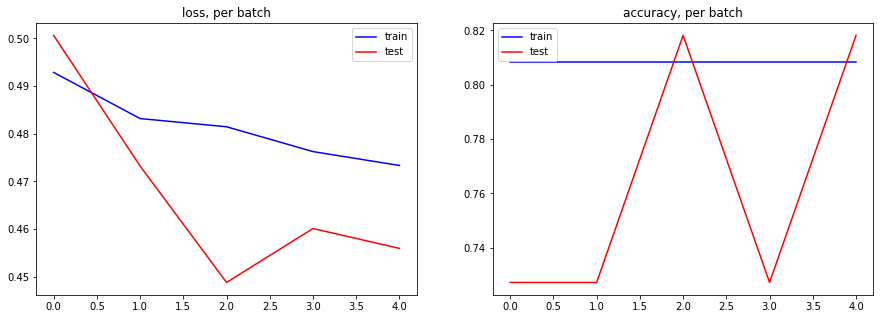

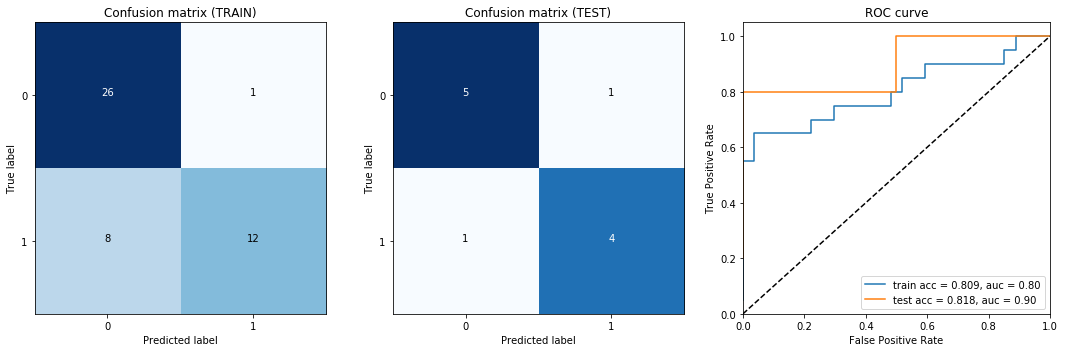

MODEL: DNN accuracy:  0.775862068966 +/-: 0.0153316758549
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.88      0.82        33
          1       0.80      0.64      0.71        25

avg / total       0.78      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


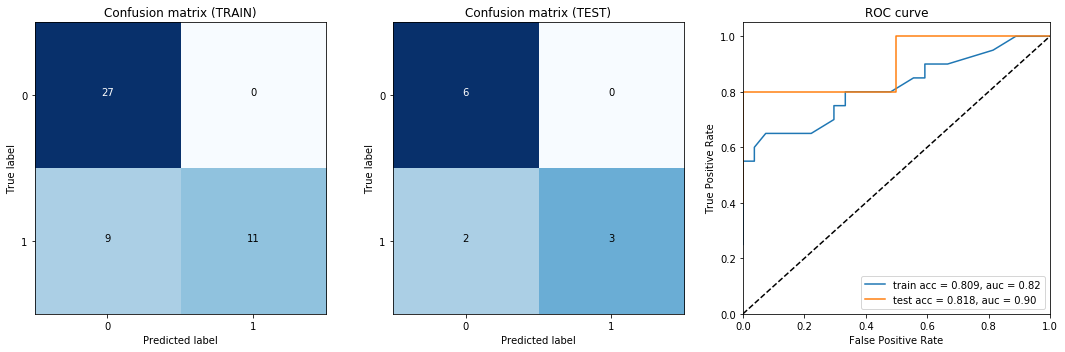

MODEL: ET accuracy:  0.775862068966 +/-: 0.00553543761035
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.94      0.83        33
          1       0.88      0.56      0.68        25

avg / total       0.80      0.78      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


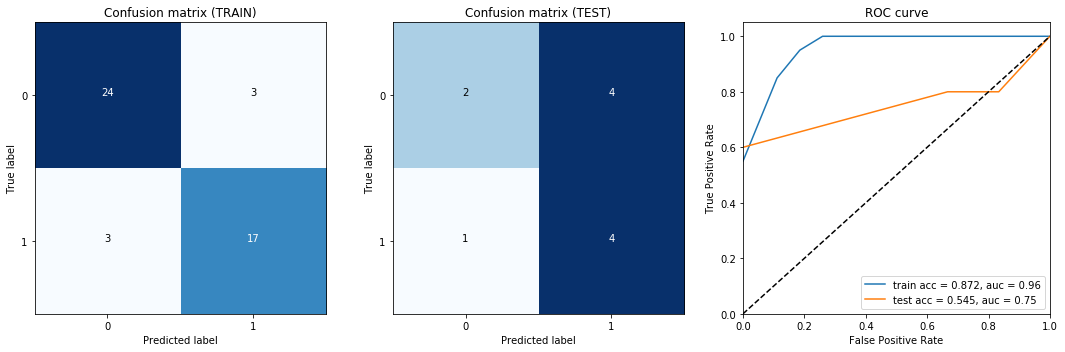

MODEL: CART accuracy:  0.741379310345 +/-: 0.0108321622888
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.85      0.79        33
          1       0.75      0.60      0.67        25

avg / total       0.74      0.74      0.74        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


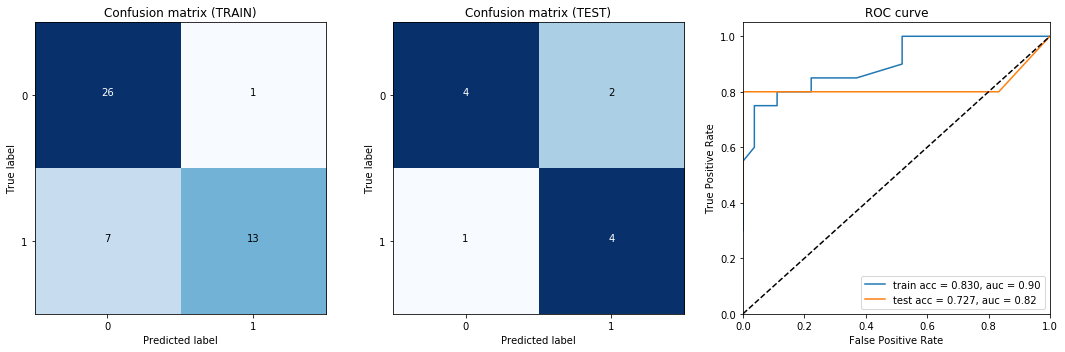

MODEL: RF accuracy:  0.775862068966 +/-: 0.0024006413721
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.75      0.91      0.82        33
          1       0.83      0.60      0.70        25

avg / total       0.79      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


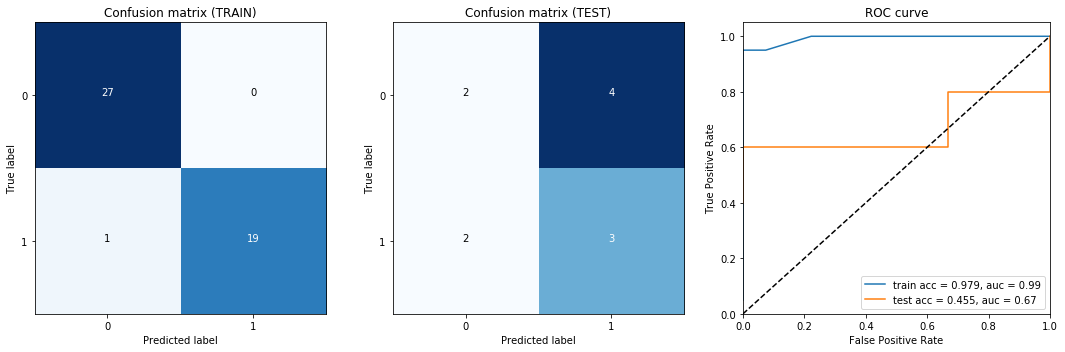

MODEL: GBM accuracy:  0.620689655172 +/-: 0.0207004648146
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.67      0.67      0.67        33
          1       0.56      0.56      0.56        25

avg / total       0.62      0.62      0.62        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


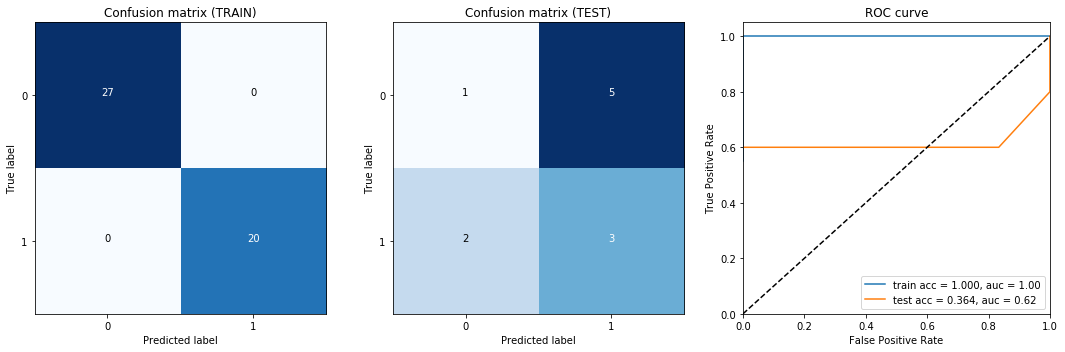

MODEL: ADA accuracy:  0.586206896552 +/-: 0.020912153641
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.65      0.61      0.62        33
          1       0.52      0.56      0.54        25

avg / total       0.59      0.59      0.59        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


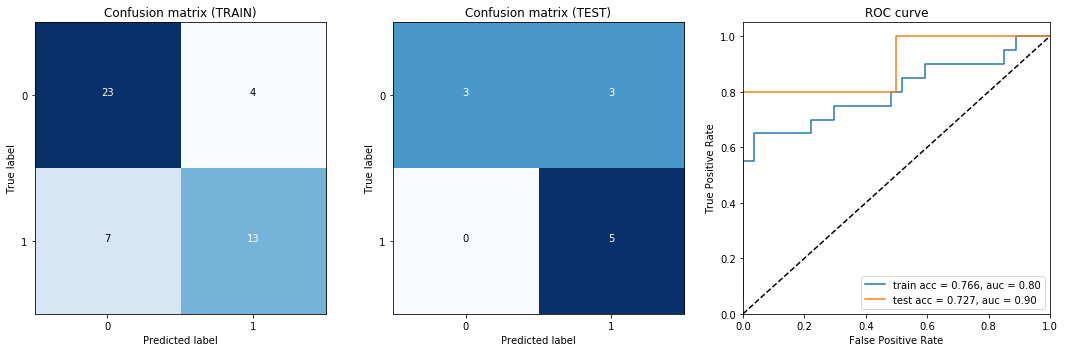

MODEL: LR accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


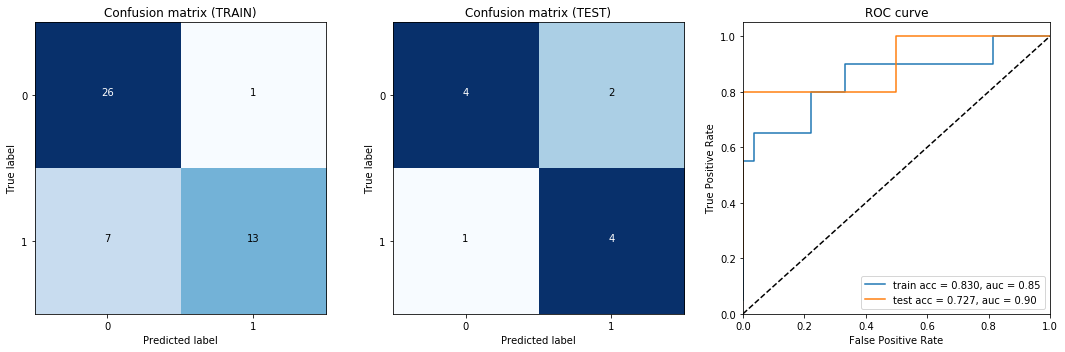

MODEL: SVM accuracy:  0.793103448276 +/-: 0.00826487226606
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.94      0.84        33
          1       0.88      0.60      0.71        25

avg / total       0.81      0.79      0.78        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


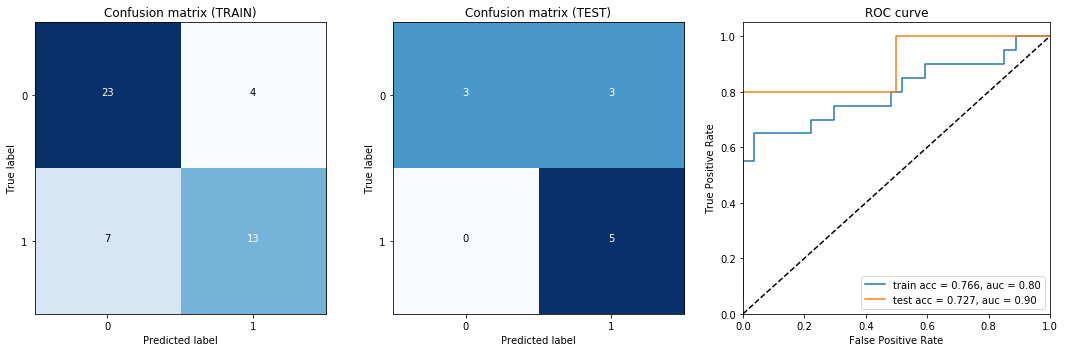

MODEL: GNB accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


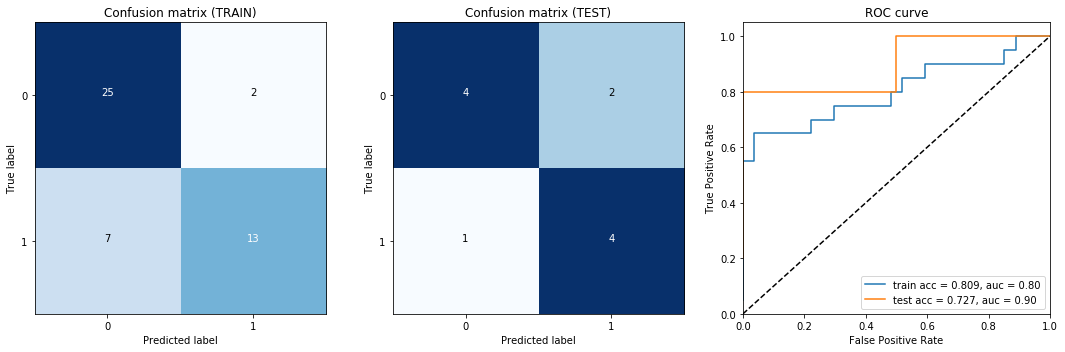

MODEL: MLNN accuracy:  0.775862068966 +/-: 0.00906208337837
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.88      0.82        33
          1       0.80      0.64      0.71        25

avg / total       0.78      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Initial alpha = [[ 0.29814633]]
   1 - L=-1804.8496513 - Gamma= 0.9999702 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-1.0491329397502411e-17
L=-1804.849651326966 - Gamma=0.999970186255669 (M=1) - s=0.01
Initial alpha = [[ 0.19279166]]
   1 - L=-1605.6273696 - Gamma= 0.9999807 (M=   1) - s=0.0100
Stopping at iteration 1 

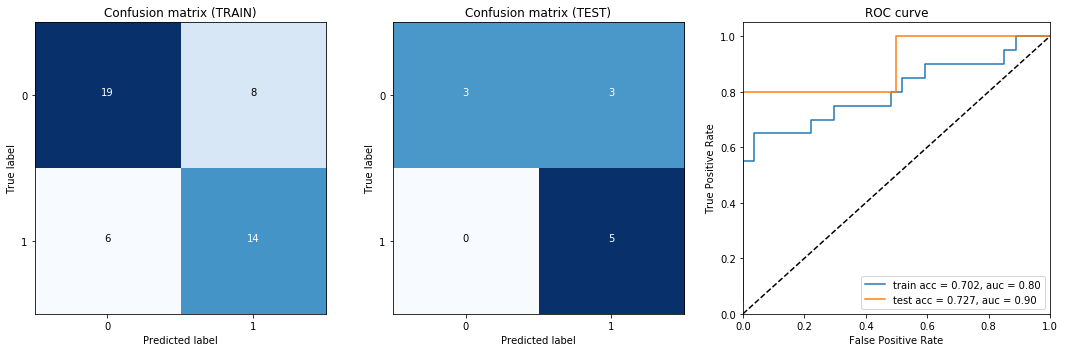

MODEL: RVM accuracy:  0.706896551724 +/-: 0.0277267322452
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.67      0.72        33
          1       0.63      0.76      0.69        25

avg / total       0.72      0.71      0.71        58

Initial alpha = [[ 0.22332277]]
   1 - L=-1764.6402811 - Gamma= 0.9999777 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-2.8460051042002094e-18
L=-1764.640281079869 - Gamma=0.9999776682216228 (M=1) - s=0.01
++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Train on 46 samples, validate on 12 samples
Epoch 1/5
46/46 [==============================] - 0s - loss: 0.6850 - acc:

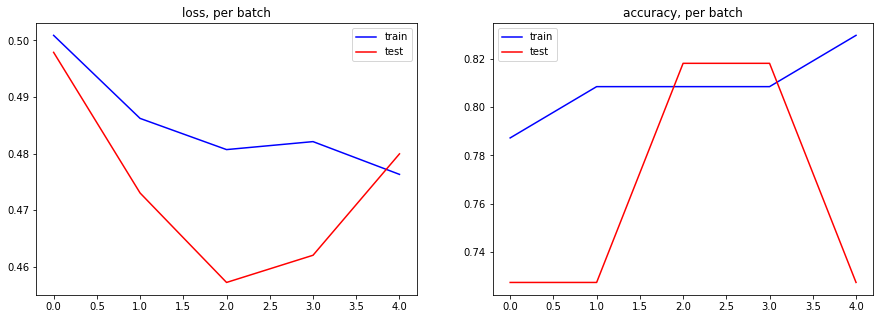

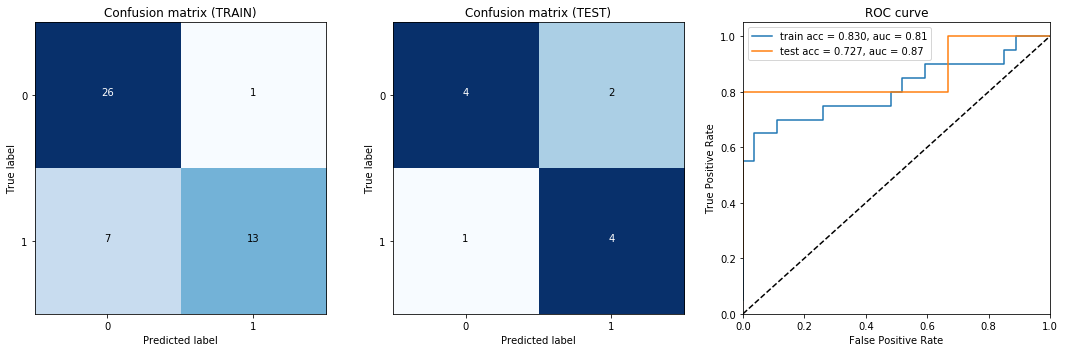

MODEL: DNN accuracy:  0.741379310345 +/-: 0.0137057255072
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.85      0.79        33
          1       0.75      0.60      0.67        25

avg / total       0.74      0.74      0.74        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


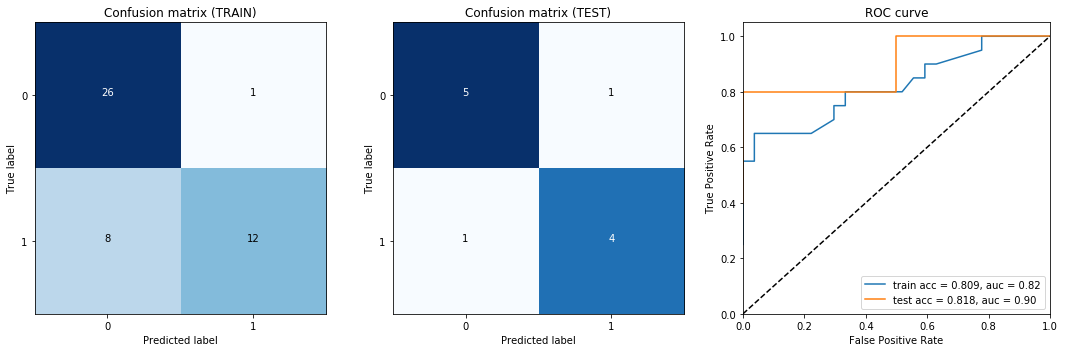

MODEL: ET accuracy:  0.775862068966 +/-: 0.00553543761035
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.75      0.91      0.82        33
          1       0.83      0.60      0.70        25

avg / total       0.79      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


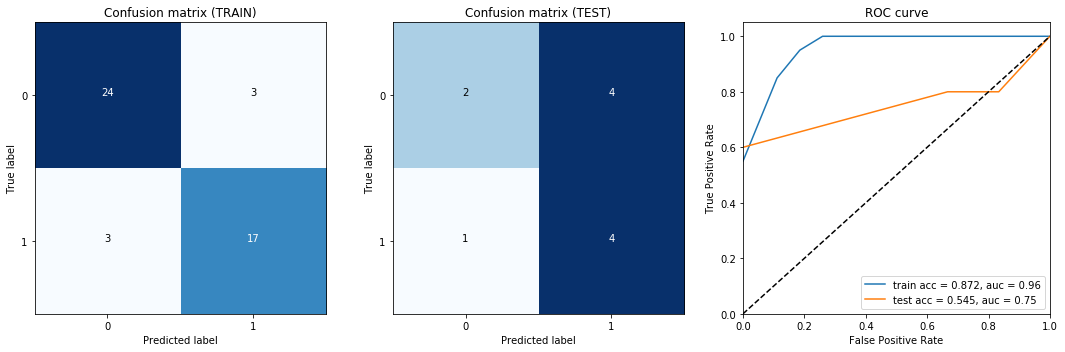

MODEL: CART accuracy:  0.741379310345 +/-: 0.0108321622888
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.85      0.79        33
          1       0.75      0.60      0.67        25

avg / total       0.74      0.74      0.74        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


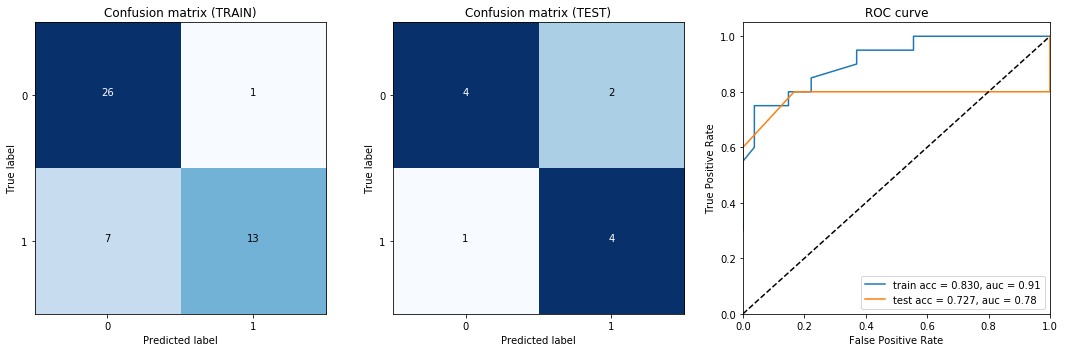

MODEL: RF accuracy:  0.775862068966 +/-: 0.0024006413721
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.75      0.91      0.82        33
          1       0.83      0.60      0.70        25

avg / total       0.79      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


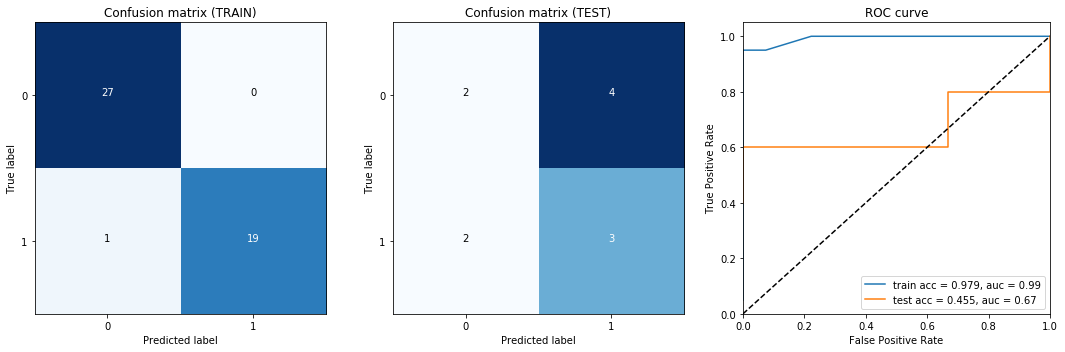

MODEL: GBM accuracy:  0.620689655172 +/-: 0.0207004648146
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.67      0.67      0.67        33
          1       0.56      0.56      0.56        25

avg / total       0.62      0.62      0.62        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


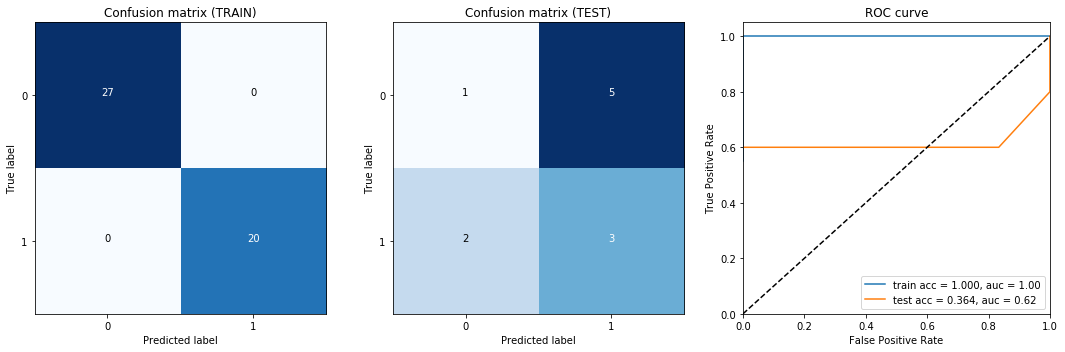

MODEL: ADA accuracy:  0.586206896552 +/-: 0.020912153641
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.65      0.61      0.62        33
          1       0.52      0.56      0.54        25

avg / total       0.59      0.59      0.59        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


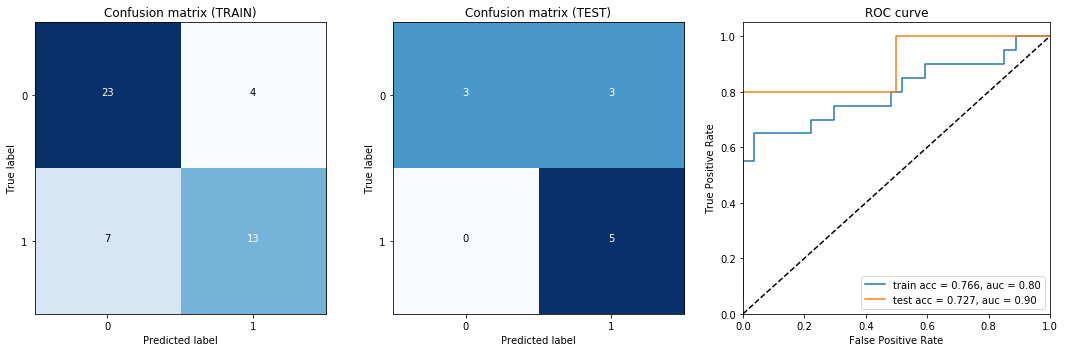

MODEL: LR accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


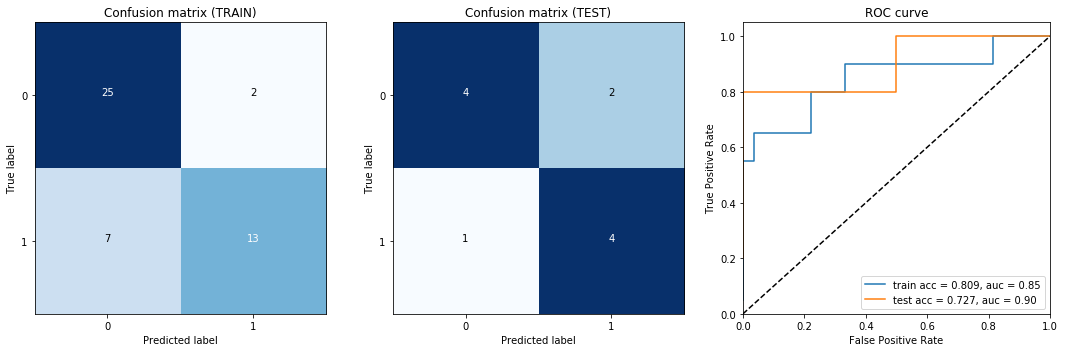

MODEL: SVM accuracy:  0.793103448276 +/-: 0.00826487226606
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.94      0.84        33
          1       0.88      0.60      0.71        25

avg / total       0.81      0.79      0.78        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


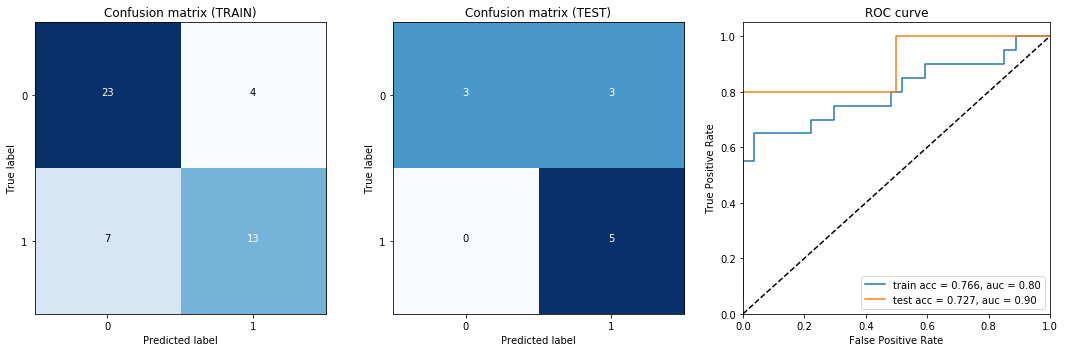

MODEL: GNB accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


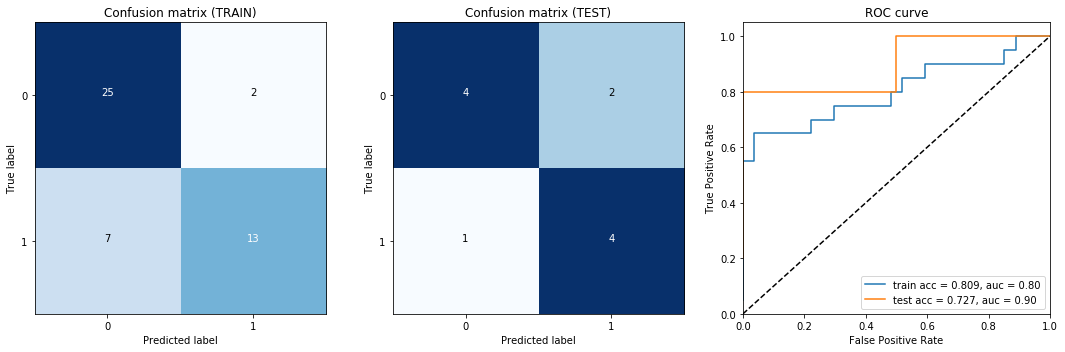

MODEL: MLNN accuracy:  0.775862068966 +/-: 0.00906208337837
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.88      0.82        33
          1       0.80      0.64      0.71        25

avg / total       0.78      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Initial alpha = [[ 0.29814633]]
   1 - L=-1804.8496513 - Gamma= 0.9999702 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-1.0491329397502411e-17
L=-1804.849651326966 - Gamma=0.999970186255669 (M=1) - s=0.01
Initial alpha = [[ 0.19279166]]
   1 - L=-1605.6273696 - Gamma= 0.9999807 (M=   1) - s=0.0100
Stopping at iteration 1 

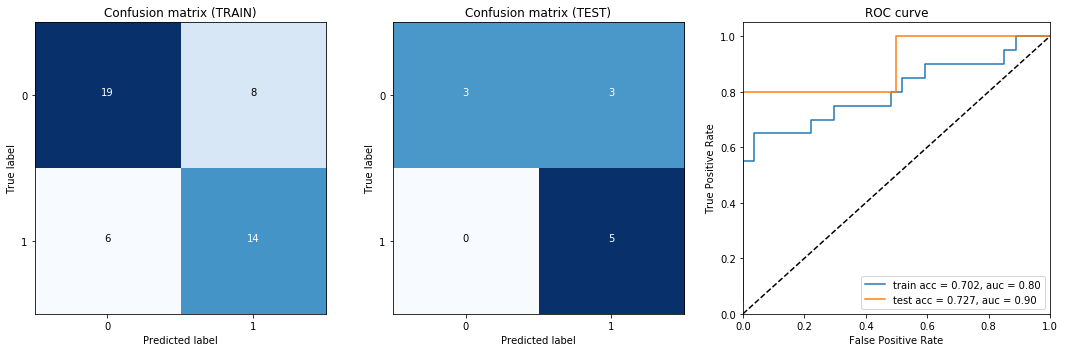

MODEL: RVM accuracy:  0.706896551724 +/-: 0.0277267322452
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.67      0.72        33
          1       0.63      0.76      0.69        25

avg / total       0.72      0.71      0.71        58

Initial alpha = [[ 0.22332277]]
   1 - L=-1764.6402811 - Gamma= 0.9999777 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-2.8460051042002094e-18
L=-1764.640281079869 - Gamma=0.9999776682216228 (M=1) - s=0.01
++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Train on 46 samples, validate on 12 samples
Epoch 1/5
46/46 [==============================] - 0s - loss: 0.8492 - acc:

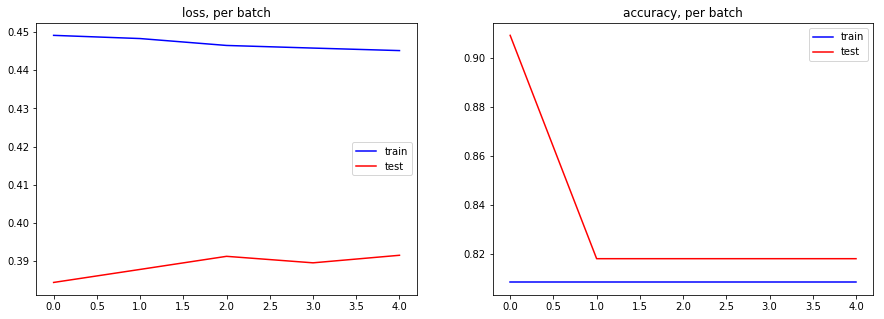

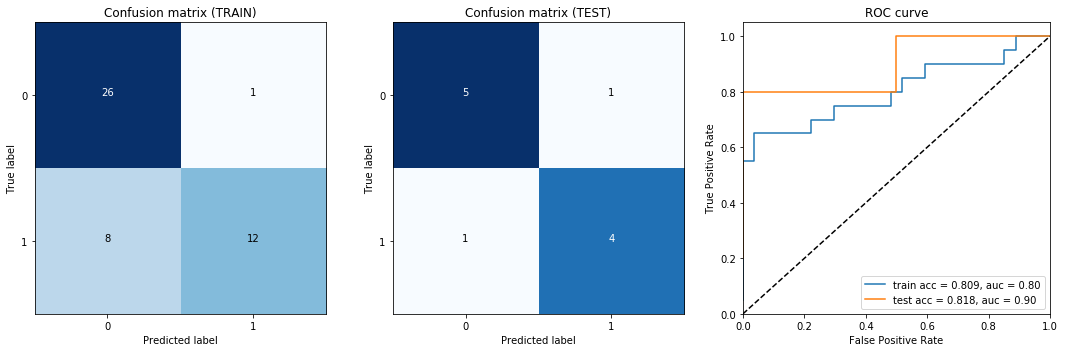

MODEL: DNN accuracy:  0.724137931034 +/-: 0.0290464093972
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.77      0.73      0.75        33
          1       0.67      0.72      0.69        25

avg / total       0.73      0.72      0.73        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


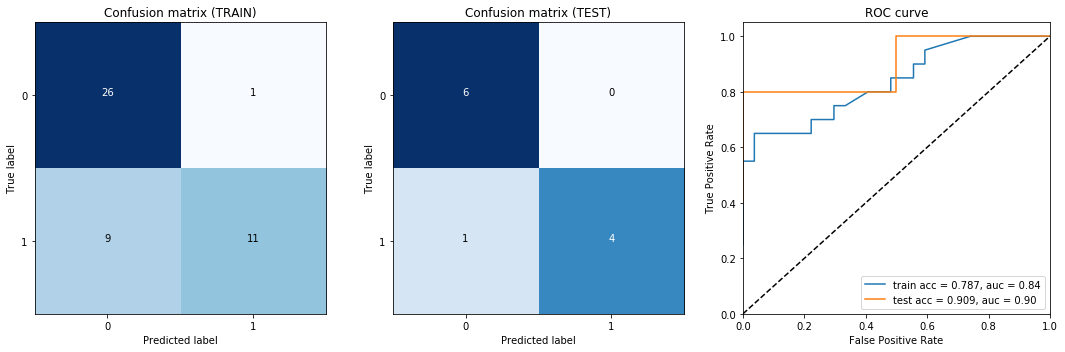

MODEL: ET accuracy:  0.810344827586 +/-: 0.00413018412424
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.97      0.85        33
          1       0.94      0.60      0.73        25

avg / total       0.84      0.81      0.80        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


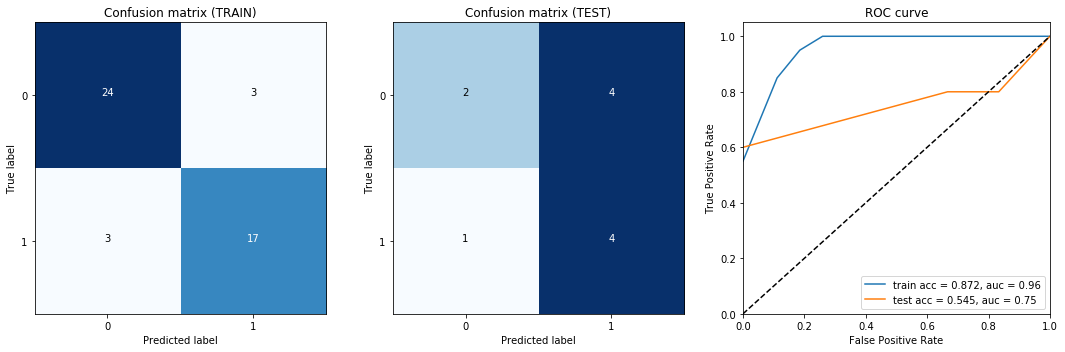

MODEL: CART accuracy:  0.741379310345 +/-: 0.0108321622888
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.85      0.79        33
          1       0.75      0.60      0.67        25

avg / total       0.74      0.74      0.74        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


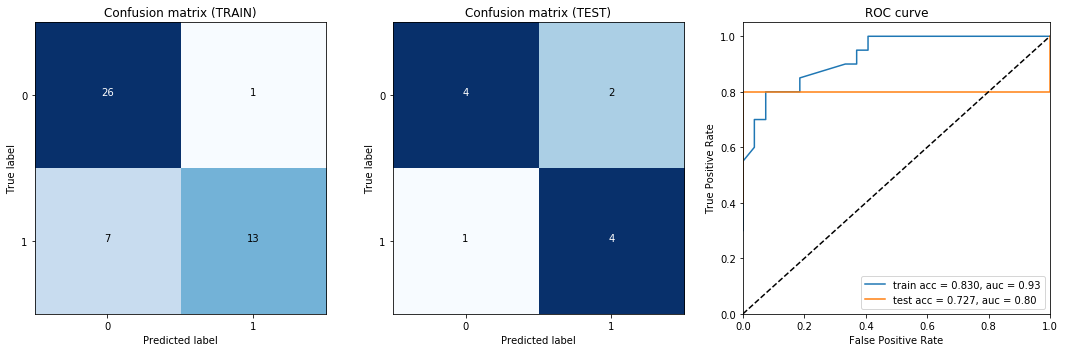

MODEL: RF accuracy:  0.775862068966 +/-: 0.0024006413721
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.75      0.91      0.82        33
          1       0.83      0.60      0.70        25

avg / total       0.79      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


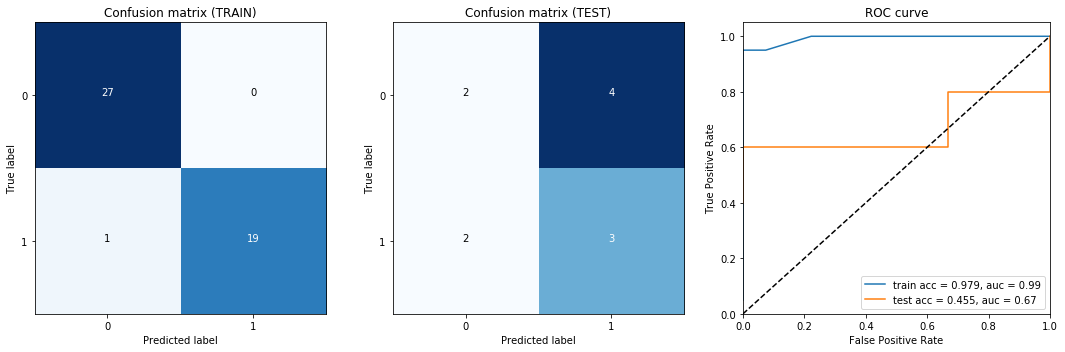

MODEL: GBM accuracy:  0.620689655172 +/-: 0.0207004648146
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.67      0.67      0.67        33
          1       0.56      0.56      0.56        25

avg / total       0.62      0.62      0.62        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


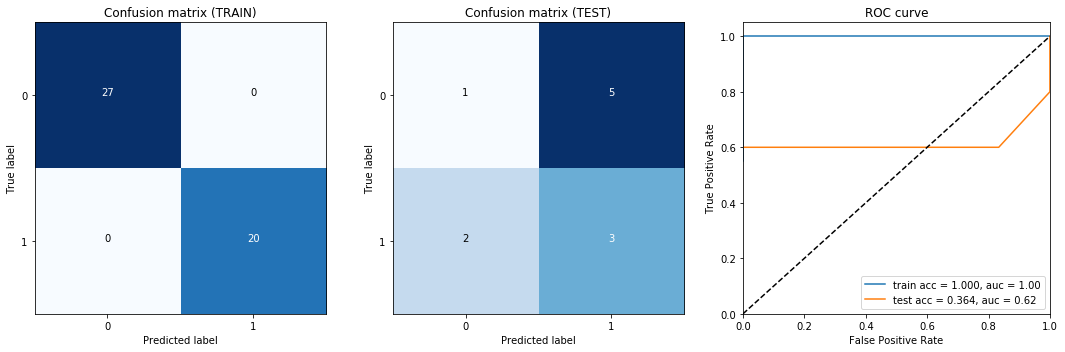

MODEL: ADA accuracy:  0.586206896552 +/-: 0.020912153641
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.65      0.61      0.62        33
          1       0.52      0.56      0.54        25

avg / total       0.59      0.59      0.59        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


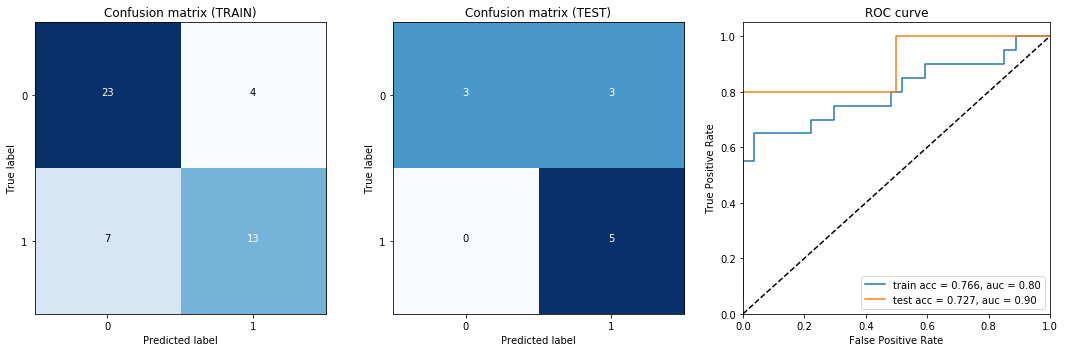

MODEL: LR accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


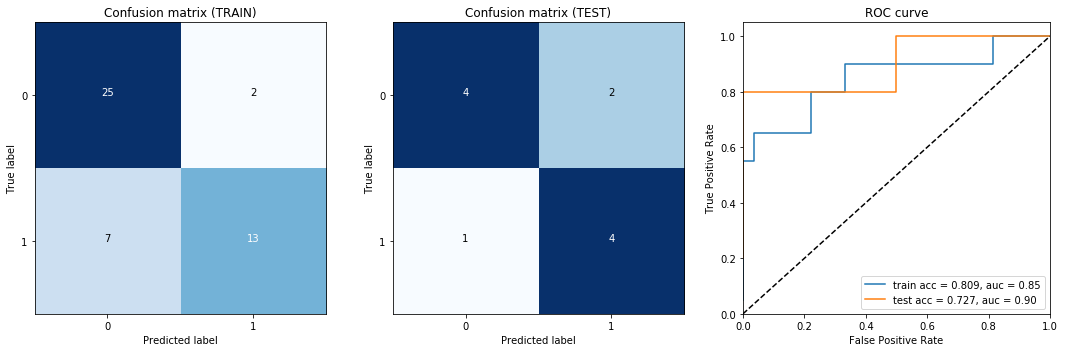

MODEL: SVM accuracy:  0.793103448276 +/-: 0.00826487226606
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.94      0.84        33
          1       0.88      0.60      0.71        25

avg / total       0.81      0.79      0.78        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


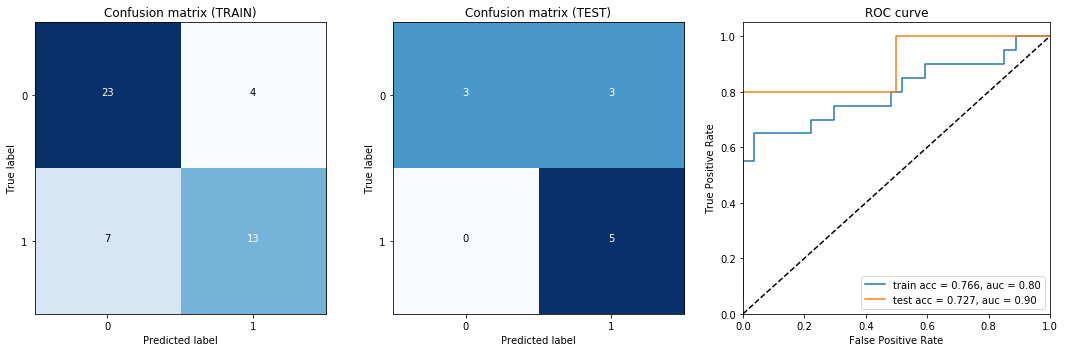

MODEL: GNB accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


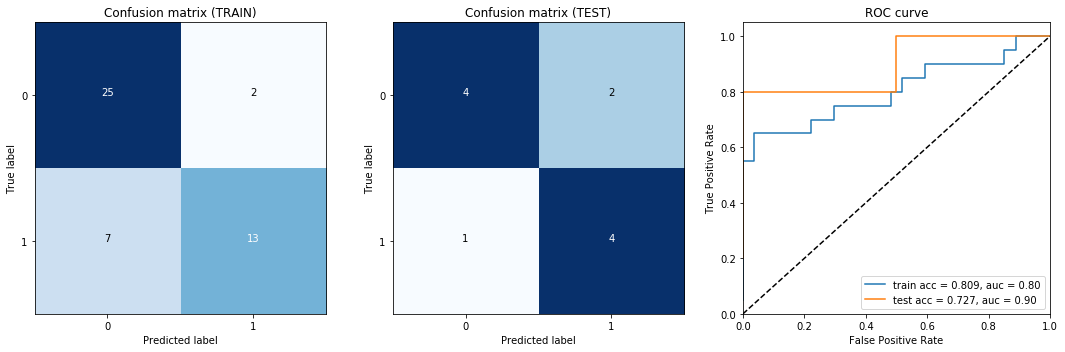

MODEL: MLNN accuracy:  0.775862068966 +/-: 0.00906208337837
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.88      0.82        33
          1       0.80      0.64      0.71        25

avg / total       0.78      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Initial alpha = [[ 0.29814633]]
   1 - L=-1804.8496513 - Gamma= 0.9999702 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-1.0491329397502411e-17
L=-1804.849651326966 - Gamma=0.999970186255669 (M=1) - s=0.01
Initial alpha = [[ 0.19279166]]
   1 - L=-1605.6273696 - Gamma= 0.9999807 (M=   1) - s=0.0100
Stopping at iteration 1 

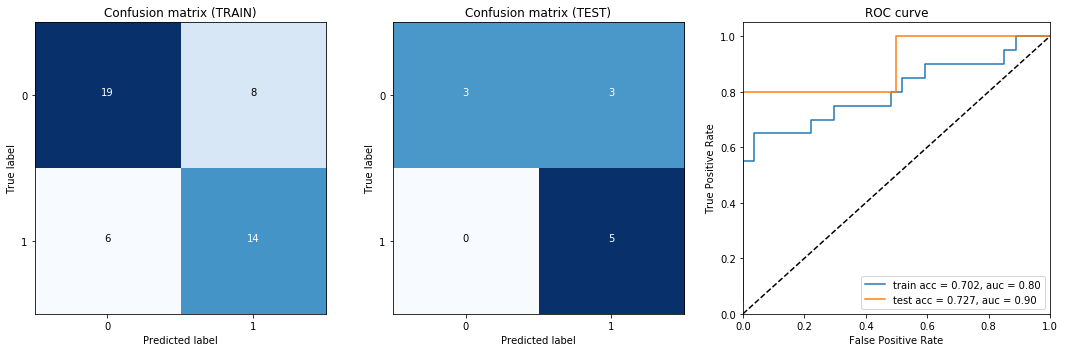

MODEL: RVM accuracy:  0.706896551724 +/-: 0.0277267322452
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.67      0.72        33
          1       0.63      0.76      0.69        25

avg / total       0.72      0.71      0.71        58

Initial alpha = [[ 0.22332277]]
   1 - L=-1764.6402811 - Gamma= 0.9999777 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-2.8460051042002094e-18
L=-1764.640281079869 - Gamma=0.9999776682216228 (M=1) - s=0.01
++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Train on 46 samples, validate on 12 samples
Epoch 1/5
46/46 [==============================] - 0s - loss: 0.8504 - acc:

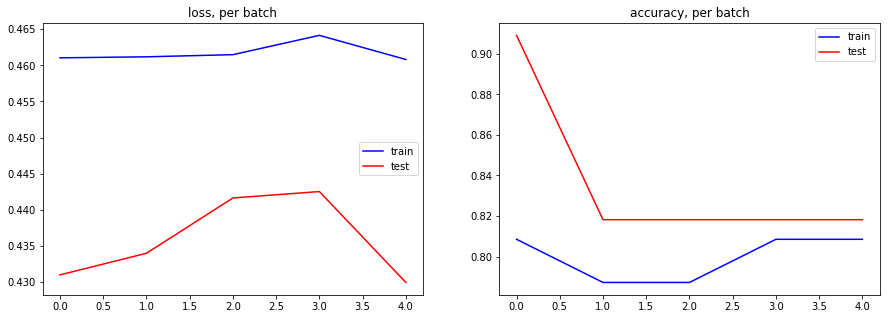

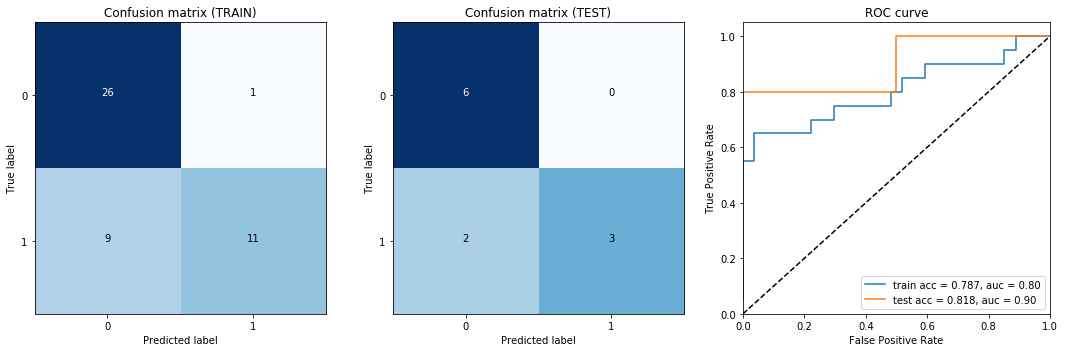

MODEL: DNN accuracy:  0.758620689655 +/-: 0.00377887075271
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.85      0.80        33
          1       0.76      0.64      0.70        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


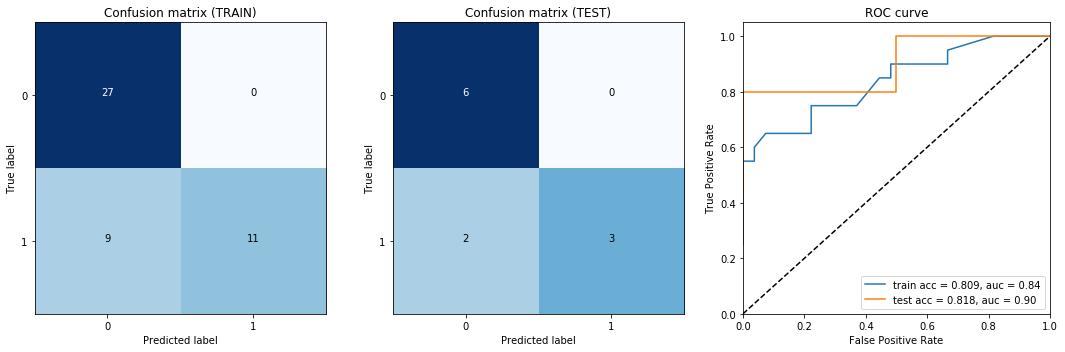

MODEL: ET accuracy:  0.775862068966 +/-: 0.00553543761035
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.94      0.83        33
          1       0.88      0.56      0.68        25

avg / total       0.80      0.78      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


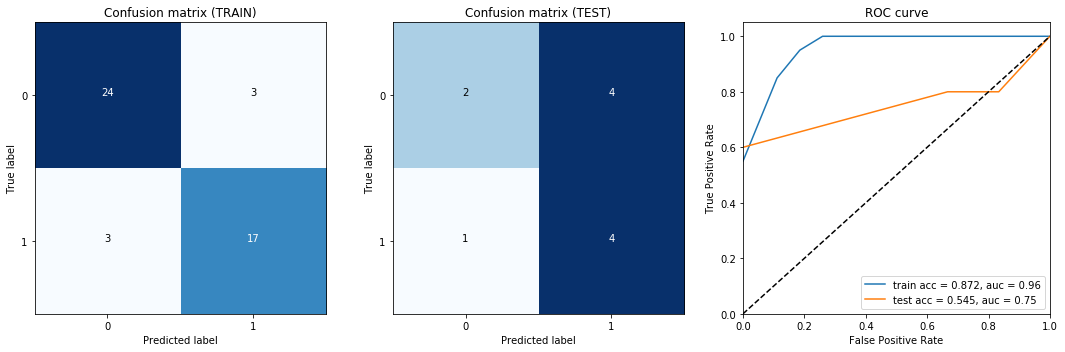

MODEL: CART accuracy:  0.741379310345 +/-: 0.0108321622888
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.74      0.85      0.79        33
          1       0.75      0.60      0.67        25

avg / total       0.74      0.74      0.74        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


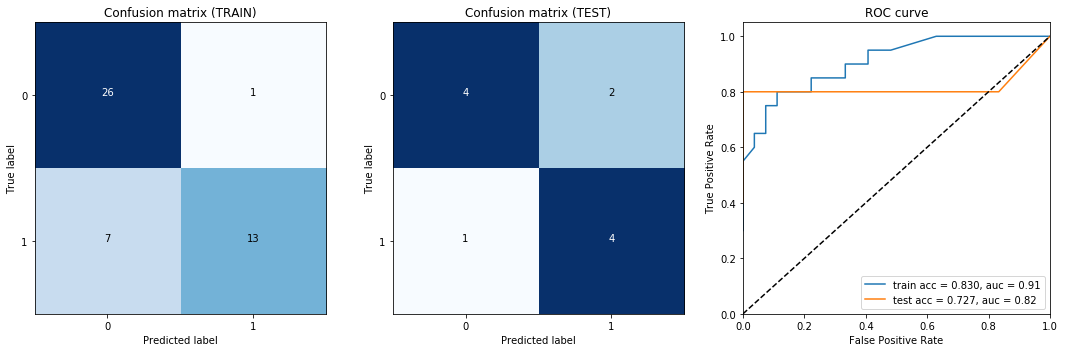

MODEL: RF accuracy:  0.775862068966 +/-: 0.0024006413721
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.75      0.91      0.82        33
          1       0.83      0.60      0.70        25

avg / total       0.79      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


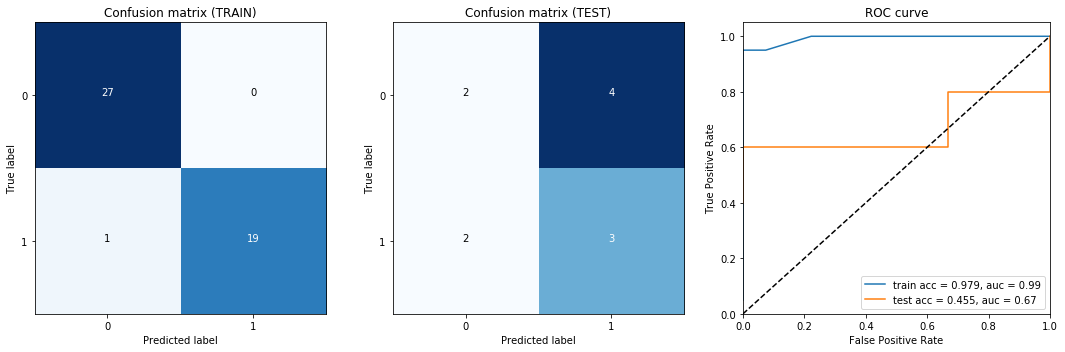

MODEL: GBM accuracy:  0.620689655172 +/-: 0.0207004648146
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.67      0.67      0.67        33
          1       0.56      0.56      0.56        25

avg / total       0.62      0.62      0.62        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


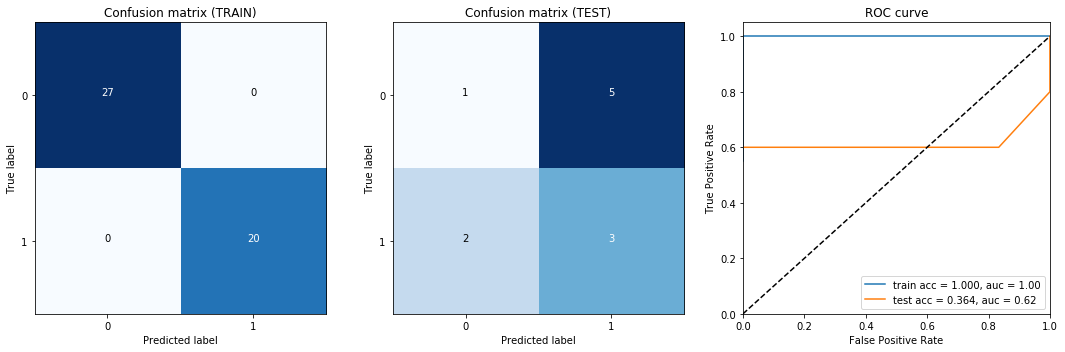

MODEL: ADA accuracy:  0.586206896552 +/-: 0.020912153641
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.65      0.61      0.62        33
          1       0.52      0.56      0.54        25

avg / total       0.59      0.59      0.59        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality


c:\users\bramva~1\envs\worken~1\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


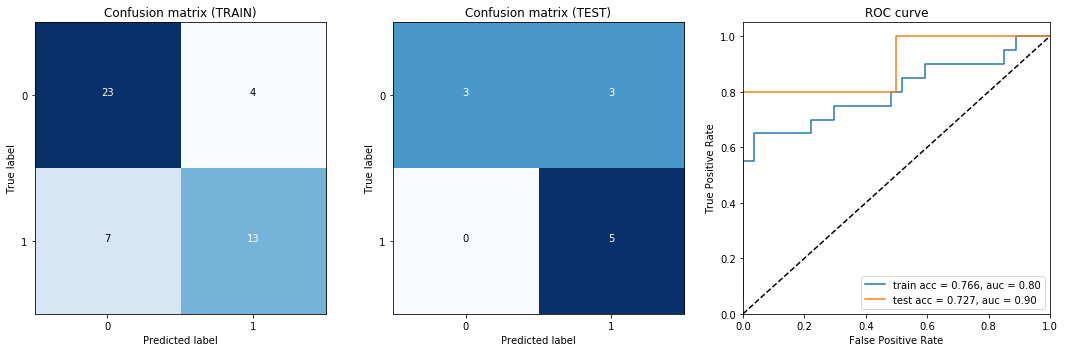

MODEL: LR accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


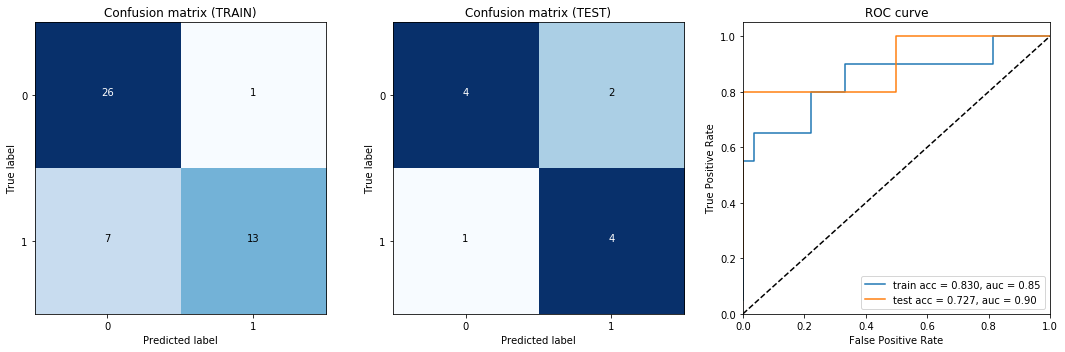

MODEL: SVM accuracy:  0.793103448276 +/-: 0.00826487226606
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.94      0.84        33
          1       0.88      0.60      0.71        25

avg / total       0.81      0.79      0.78        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


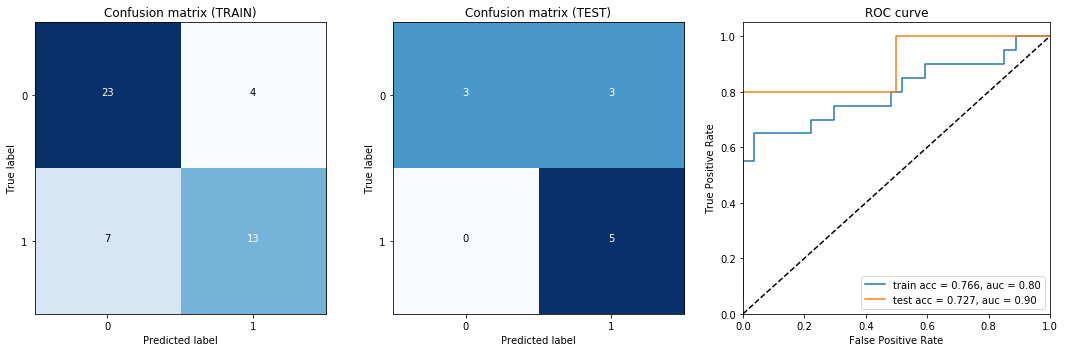

MODEL: GNB accuracy:  0.758620689655 +/-: 0.0280735415991
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.79      0.79        33
          1       0.72      0.72      0.72        25

avg / total       0.76      0.76      0.76        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++


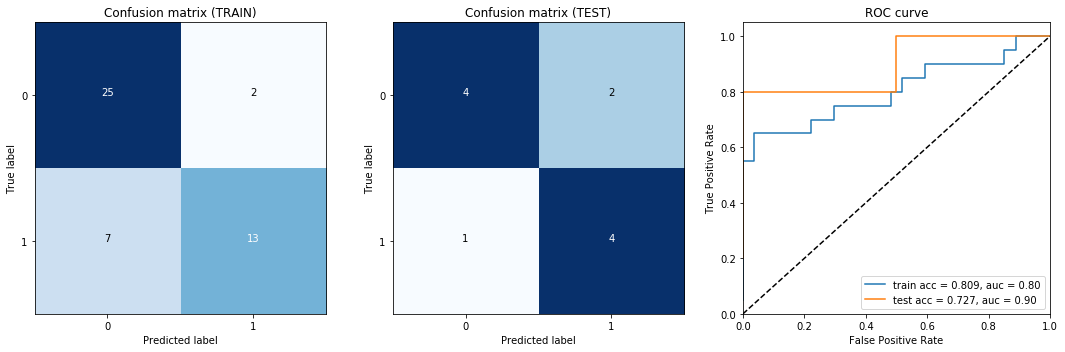

MODEL: MLNN accuracy:  0.775862068966 +/-: 0.00906208337837
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.76      0.88      0.82        33
          1       0.80      0.64      0.71        25

avg / total       0.78      0.78      0.77        58

++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Initial alpha = [[ 0.29814633]]
   1 - L=-1804.8496513 - Gamma= 0.9999702 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-1.0491329397502411e-17
L=-1804.849651326966 - Gamma=0.999970186255669 (M=1) - s=0.01
Initial alpha = [[ 0.19279166]]
   1 - L=-1605.6273696 - Gamma= 0.9999807 (M=   1) - s=0.0100
Stopping at iteration 1 

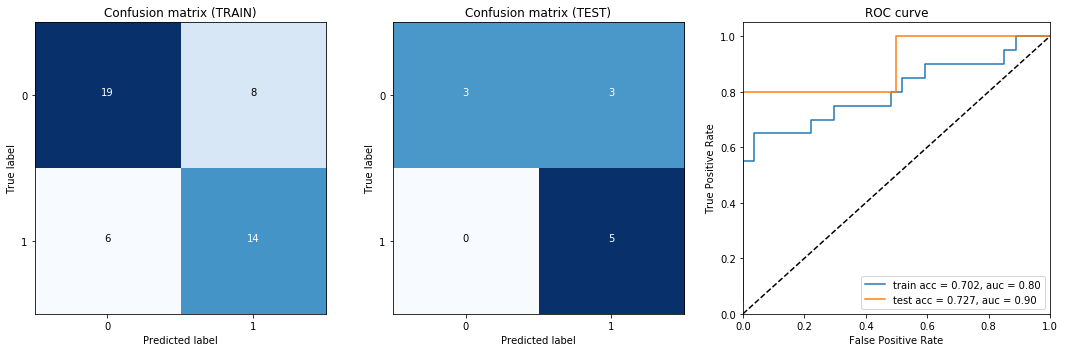

MODEL: RVM accuracy:  0.706896551724 +/-: 0.0277267322452
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.79      0.67      0.72        33
          1       0.63      0.76      0.69        25

avg / total       0.72      0.71      0.71        58

Initial alpha = [[ 0.22332277]]
   1 - L=-1764.6402811 - Gamma= 0.9999777 (M=   1) - s=0.0100
Stopping at iteration 1 - max_delta_ml=-2.8460051042002094e-18
L=-1764.640281079869 - Gamma=0.9999776682216228 (M=1) - s=0.01
++++++++++++++++++++++++++++++++++++++++++++++++++
+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + +  Creating X,y
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Reducing dimensionality
++++++++++++++++++++++++++++++  RESULTS FOR CLASSIFICATION WITH GENOMIC DATA ++++++++++++++++++++++++++++++
Train on 46 samples, validate on 12 samples
Epoch 1/5
46/46 [==============================] - 0s - loss: 0.6798 - acc:

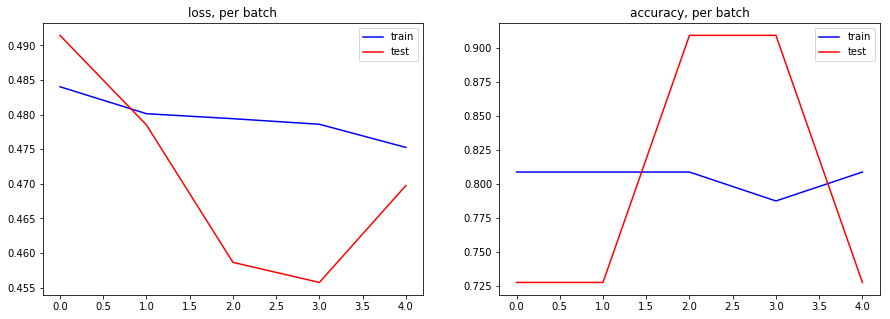

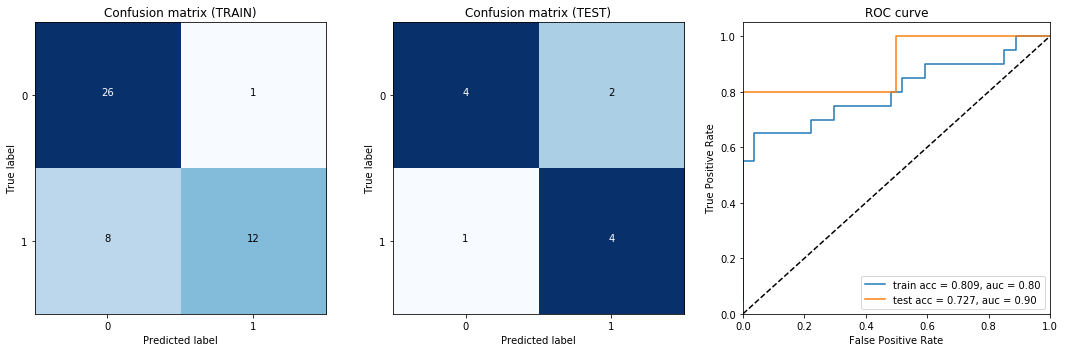

MODEL: DNN accuracy:  0.793103448276 +/-: 0.0121833675639
++++++++++++++++++++++++++++++  Report ++++++++++++++++++++++++++++++
             precision    recall  f1-score   support

          0       0.78      0.88      0.83        33
          1       0.81      0.68      0.74        25

avg / total       0.79      0.79      0.79        58

++++++++++++++++++++++++++++++++++++++++++++++++++


In [88]:
METHOD_LIST = ['ExtraTrees', 'CART', 'RandomForest', 'GBM', 'AdaBoost', 'LR', 'SVM', 'NaiveBayes', 'MLNN']
Runs = []
nruns = 10
SCALER = "minmax"
GROUPING = "mean"
DIM_TYPE = "LDA"
DIM_NUM = 1000

for i in range(0, nruns):
    Results = Rocket.DATA_merged_processed.copy()
    MODELS  = []
    for idx, METHOD in enumerate(METHOD_LIST):
        preds, class_model = Rocket.classify_treatment(model_type = METHOD, 
                                                      features = 'genomic',
                                                      parameters = {},
                                                      pipeline = {"scaler": {"type": SCALER},
                                                                  "pre_processing": {"patient_grouping": GROUPING, 
                                                                                     "bias_removal": False},
                                                                  "dim_reduction": {"type": DIM_TYPE, "n_comp": DIM_NUM},
                                                                  "feature_selection": {"type": "RFECV", "top_n": 100}})
        MODELS.append(class_model)
        preds = [pred_[1]for pred_ in preds]
        #len(Rocket.DATA_merged[Rocket.DATA_merged["array-batch"].isin(["cohort 1", "cohort 2", "JB", "IA", "ALL-10"])])
        Results['pred'] = preds
        Results['method'] = METHOD
        if idx == 0:
            AllResults = Results[['labnr_patient', 'pred', 'method', 'Treatment_risk_group_in_ALL10']]
        else:
            AllResults = AllResults.append(Results[['labnr_patient', 'pred', 'method', 'Treatment_risk_group_in_ALL10']], 
                                      ignore_index = True)

    ####
    ####

    preds, class_model = Rocket.classify_treatment(model_type = "RVM", 
                                                      features = 'genomic',
                                                      parameters = {},
                                                      pipeline = {"scaler": {"type": SCALER},
                                                                  "pre_processing": {"patient_grouping": GROUPING, 
                                                                                     "bias_removal": False},
                                                                  "dim_reduction": {"type": DIM_TYPE, "n_comp": DIM_NUM},
                                                                  "feature_selection": {"type": "RFECV", "top_n": 100}})
    MODELS.append(class_model)
    Results = Rocket.DATA_merged_processed.copy()
    preds = [pred_ for pred_ in preds]
    Results['pred'] = preds
    Results['method'] = "RVM"
    AllResults = AllResults.append(Results[['labnr_patient', 'pred', 'method', 'Treatment_risk_group_in_ALL10']], ignore_index = True)

    ####
    ####

    preds, class_model = Rocket.classify_treatment(model_type = "DNN", 
                                                      features = 'genomic',
                                                      parameters = {},
                                                      pipeline = {"scaler": {"type": SCALER},
                                                                  "pre_processing": {"patient_grouping": GROUPING, 
                                                                                     "bias_removal": False},
                                                                  "dim_reduction": {"type": DIM_TYPE, "n_comp": DIM_NUM},
                                                                  "feature_selection": {"type": "RFECV", "top_n": 100}})
    MODELS.append(class_model)
    Results = Rocket.DATA_merged_processed.copy()
    preds = [pred_ for pred_ in preds]
    Results['pred'] = preds
    Results['method'] = "DNN"
    AllResults = AllResults.append(Results[['labnr_patient', 'pred', 'method', 'Treatment_risk_group_in_ALL10']], ignore_index = True)

    AllResults['labnr_patient'] = AllResults['labnr_patient'].astype('str')
    AllResults = AllResults.sort_values(by='labnr_patient')
    #AllResults[AllResults['Treatment_risk_group_in_ALL10'].notnull()]
    ####
    ####
    Runs.append(AllResults)

###########
###########
##Runs.append(AllResults)
final_df = pandas.DataFrame()
for idx, df in enumerate(Runs):
    df['run'] = idx
    final_df = final_df.append(df, ignore_index = True)
final_df = final_df.sort_values(by='labnr_patient')
final_df['pred']= pandas.to_numeric(final_df['pred'])
final_df = final_df.groupby(['labnr_patient', 'method']).agg({'pred': [numpy.mean, numpy.median, numpy.std]})
final_df.to_csv("C:/Users/Bram van Es/DEV/RexR/out/patient_results.csv")